## This Notebook Contains Models to Predict How Many Fatalities Are Likely to Occur Depending on Various Features

Importing libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn import svm
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

%matplotlib inline 

In [2]:
#Reading in hurdat.csv dataset (this dataset was cleaned by Drew Dyson and was saved in the data folder):
df = pd.read_csv('../data/hurdat_population.csv')

In [3]:
#Inspecting dimensions of the dataset:
df.shape

(23729, 32)

In [4]:
#Looking at the column names of the dataset:
df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Date', 'Time', 'Event', 'Status',
       'Latitude', 'Longitude', 'Maximum Wind', 'Minimum Pressure',
       'Low Wind NE', 'Low Wind SE', 'Low Wind SW', 'Low Wind NW',
       'Moderate Wind NE', 'Moderate Wind SE', 'Moderate Wind SW',
       'Moderate Wind NW', 'High Wind NE', 'High Wind SE', 'High Wind SW',
       'High Wind NW', 'Year', 'Month', 'Day', 'lat', 'lng', 'county_name',
       'state_name', 'population', 'Population'],
      dtype='object')

In [5]:
#Inspecting the head of the dataset:
df.head()

,Unnamed: 0,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,...,High Wind NW,Year,Month,Day,lat,lng,county_name,state_name,population,Population
0,0,AL011950,ABLE,19500812.0,0.0,NaN,TS,17.1,55.5,35.0,...,NaN,1950,8,12,17.0,-55.1,Miami Dade,Florida,NaN,0
1,1,AL011950,ABLE,19500812.0,600.0,NaN,TS,17.7,56.3,40.0,...,NaN,1950,8,12,17.1,-56.0,Miami Dade,Florida,NaN,0
2,2,AL011950,ABLE,19500812.0,1200.0,NaN,TS,18.2,57.4,45.0,...,NaN,1950,8,12,18.0,-57.1,Miami Dade,Florida,NaN,0
3,3,AL011950,ABLE,19500812.0,1800.0,NaN,TS,19.0,58.6,50.0,...,NaN,1950,8,12,19.0,-58.1,Miami Dade,Florida,NaN,0
4,4,AL011950,ABLE,19500813.0,0.0,NaN,TS,20.0,60.0,50.0,...,NaN,1950,8,13,20.0,-60.0,Miami Dade,Florida,NaN,0


In [6]:
#Removing the Unnamed: 0 column because it does not include useful info
df.drop(columns = 'Unnamed: 0', index=1, inplace=True)

In [7]:
#Checking dropped the column 'Unnamed: 0'
df.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,High Wind NW,Year,Month,Day,lat,lng,county_name,state_name,population,Population
0,AL011950,ABLE,19500812.0,0.0,NaN,TS,17.1,55.5,35.0,NaN,...,NaN,1950,8,12,17.0,-55.1,Miami Dade,Florida,NaN,0
2,AL011950,ABLE,19500812.0,1200.0,NaN,TS,18.2,57.4,45.0,NaN,...,NaN,1950,8,12,18.0,-57.1,Miami Dade,Florida,NaN,0
3,AL011950,ABLE,19500812.0,1800.0,NaN,TS,19.0,58.6,50.0,NaN,...,NaN,1950,8,12,19.0,-58.1,Miami Dade,Florida,NaN,0
4,AL011950,ABLE,19500813.0,0.0,NaN,TS,20.0,60.0,50.0,NaN,...,NaN,1950,8,13,20.0,-60.0,Miami Dade,Florida,NaN,0
5,AL011950,ABLE,19500813.0,600.0,NaN,TS,20.7,61.1,50.0,NaN,...,NaN,1950,8,13,20.1,-61.0,Miami Dade,Florida,NaN,0


In [8]:
#Inspecting when got more complete data:
#df[df['Year'] == 2004] #supressed this cell to save space in this notebook

In [9]:
#Looking at the number of rows with each type of storm:
df['Status'].value_counts()

TS    7943
HU    6852
TD    4580
EX    2471
LO    1120
SS     309
SD     216
DB     123
WV     114
Name: Status, dtype: int64

In [10]:
#Looking at the dimensions of the dataframe again:
df.shape

(23728, 31)

In [11]:
#Setting values in Date column to integers:
#df['Date'] = df['Date'].astype(int)

In [12]:
#Setting values in Date column to strings:
#df['Date'] = df['Date'].astype(str)

In [13]:
#Creating year, month, and day columns:
# year_list = []
# month_list = []
# day_list = []
# for i in range(len(df['Date'])):
#     year_list.append(df['Date'].iloc[i][0:4])
#     month_list.append(df['Date'].iloc[i][4:6])
#     day_list.append(df['Date'].iloc[i][6:8])
    
# df['Year'] = year_list
# df['Month'] = month_list
# df['Day'] = day_list
# df.head()

In [14]:
#Creating df_HU which will include only hurricanes:
df_HU = df[(df['Status'] == 'HU')]

In [15]:
#Checking dimensions of df_HU:
df_HU.shape

(6852, 31)

In [16]:
#Looking at how many unique hurricanes exist in df_HU:
len(df_HU['ID'].unique())

417

In [17]:
#Looking at datatypes of columns in df_HU:
df_HU.dtypes

ID                   object
Name                 object
Date                float64
Time                float64
Event                object
Status               object
Latitude            float64
Longitude           float64
Maximum Wind        float64
Minimum Pressure    float64
Low Wind NE         float64
Low Wind SE         float64
Low Wind SW         float64
Low Wind NW         float64
Moderate Wind NE    float64
Moderate Wind SE    float64
Moderate Wind SW    float64
Moderate Wind NW    float64
High Wind NE        float64
High Wind SE        float64
High Wind SW        float64
High Wind NW        float64
Year                  int64
Month                 int64
Day                   int64
lat                 float64
lng                 float64
county_name          object
state_name           object
population          float64
Population            int64
dtype: object

In [18]:
#Creating lists of hurricane ID's, Names, Years, and Months:
list_ids = []
list_names = []
list_years = []
list_months = []
for i in range(1,len(df_HU['Name'])):
    if df_HU.iloc[i]['Name'] != df_HU.iloc[i-1]['Name']:
        list_ids.append(df_HU.iloc[i]['ID'])
        list_names.append(df_HU.iloc[i]['Name'])
        list_years.append(df_HU.iloc[i]['Year'])
        list_months.append(df_HU.iloc[i]['Month'])

#Placing hurricane IDs, names, years, and months into a dataframe:        
df_HU_NmYrMo = pd.DataFrame()
df_HU_NmYrMo['ID'] = list_ids
df_HU_NmYrMo['HU Name'] = list_names
df_HU_NmYrMo['Year_Name_Used'] = list_years
df_HU_NmYrMo['Month_of_Storm'] = list_months

In [19]:
#Inspecting the head of the dataframe:
df_HU_NmYrMo.head()

,ID,HU Name,Year_Name_Used,Month_of_Storm
0,AL021950,BAKER,1950,8
1,AL031950,CHARLIE,1950,8
2,AL041950,DOG,1950,8
3,AL051950,EASY,1950,9
4,AL061950,FOX,1950,9


In [20]:
#Decided to only look at data during and after 1969 because only have population information after that time
#(and the quality of reporting of hurricane fatalities was not optimal before 1969)
df_HU_NmYrMo_post1968 = df_HU_NmYrMo[df_HU_NmYrMo['Year_Name_Used'] >= 1969]
df_HU_NmYrMo_post1968.head()
#Source of population data we plan to use (if we can unpack the .exe file):
#https://seer.cancer.gov/popdata/popdic.html

,ID,HU Name,Year_Name_Used,Month_of_Storm
114,AL071969,BLANCHE,1969,8
115,AL081969,DEBBIE,1969,8
116,AL091969,CAMILLE,1969,8
117,AL131969,FRANCELIA,1969,9
118,AL161969,GERDA,1969,9


In [21]:
#The list of the 303 hurricanes that hit from the Atlantic during or after 1969 until 2017
#Note that this list includes hurricanes that may not have had landfall since some hurricanes that 
#do not hit land still can cause flooding, high winds, etc.
df_HU_NmYrMo_post1968.reset_index(drop = True, inplace = True)
df_HU_NmYrMo_post1968.head()

,ID,HU Name,Year_Name_Used,Month_of_Storm
0,AL071969,BLANCHE,1969,8
1,AL081969,DEBBIE,1969,8
2,AL091969,CAMILLE,1969,8
3,AL131969,FRANCELIA,1969,9
4,AL161969,GERDA,1969,9


In [22]:
#Checking the dimensions of the dataframe:
df_HU_NmYrMo_post1968.shape

(303, 4)

In [23]:
#Creating a dataframe with all hurricane data after 1968:
df_HU_post1968 = df_HU[df_HU['Year'] >= 1969]
#Resetting the index for future use of the dataframe:
df_HU_post1968.reset_index(drop = True, inplace = True)
#Inspecting the head of the dataframe:
df_HU_post1968.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,High Wind NW,Year,Month,Day,lat,lng,county_name,state_name,population,Population
0,AL071969,BLANCHE,19690811.0,1800.0,NaN,HU,35.5,69.9,75.0,997.0,...,NaN,1969,8,11,35.1,-69.2,Nantucket,Massachusetts,NaN,10124
1,AL071969,BLANCHE,19690812.0,0.0,NaN,HU,38.6,68.0,75.0,NaN,...,NaN,1969,8,12,38.1,-68.0,Nantucket,Massachusetts,NaN,10124
2,AL071969,BLANCHE,19690812.0,600.0,NaN,HU,41.7,65.0,75.0,NaN,...,NaN,1969,8,12,41.1,-65.0,Washington,Maine,NaN,32715
3,AL071969,BLANCHE,19690812.0,1200.0,NaN,HU,44.3,60.4,65.0,998.0,...,NaN,1969,8,12,44.0,-60.1,Washington,Maine,NaN,32715
4,AL081969,DEBBIE,19690816.0,1800.0,NaN,HU,15.5,48.0,65.0,NaN,...,NaN,1969,8,16,15.1,-48.0,Miami Dade,Florida,NaN,0


In [24]:
#Creating a dataframe including hurricanes that made landfall:
df_HU_post1968_L = df_HU_post1968[df_HU_post1968['Event'] == 'L']
#Checked work:
#df_HU_post1968_L.head()

#Inspecting the hurricane ID's of hurricanes that made landfall:
df_HU_post1968_L_ids = list(set(df_HU_post1968_L['ID']))
df_HU_post1968_L_ids

['AL132002',
 'AL042008',
 'AL052016',
 'AL121996',
 'AL112004',
 'AL082003',
 'AL172008',
 'AL031991',
 'AL071998',
 'AL041985',
 'AL171995',
 'AL131987',
 'AL072017',
 'AL112009',
 'AL021996',
 'AL051985',
 'AL061996',
 'AL132017',
 'AL042007',
 'AL081999',
 'AL101984',
 'AL132007',
 'AL152003',
 'AL082014',
 'AL152001',
 'AL091969',
 'AL092016',
 'AL092004',
 'AL131985',
 'AL072014',
 'AL041989',
 'AL091985',
 'AL191995',
 'AL142016',
 'AL112017',
 'AL031999',
 'AL031996',
 'AL111989',
 'AL062004',
 'AL051998',
 'AL012010',
 'AL122005',
 'AL032005',
 'AL051995',
 'AL111988',
 'AL082008',
 'AL192010',
 'AL051986',
 'AL132003',
 'AL112015',
 'AL041983',
 'AL161999',
 'AL112001',
 'AL071988',
 'AL021986',
 'AL131998',
 'AL141999',
 'AL072000',
 'AL092012',
 'AL072008',
 'AL131995',
 'AL051999',
 'AL182005',
 'AL162016',
 'AL042005',
 'AL012014',
 'AL152000',
 'AL202005',
 'AL141989',
 'AL151995',
 'AL212010',
 'AL042003',
 'AL132010',
 'AL032004',
 'AL021985',
 'AL152017',
 'AL051997',

In [25]:
#Finding the number of hurricanes that made landfall:
len(df_HU_post1968_L_ids)

107

In [26]:
#Making a list of storms that did not have landfall:
df_HU_post1968_NO_L_ids = [] 
for i in list(set(df_HU_post1968['ID'])):
    if i not in df_HU_post1968_L_ids:
        df_HU_post1968_NO_L_ids.append(i)

In [27]:
#Finding the number of hurricanes that did not make landfall:
len(df_HU_post1968_NO_L_ids)

196

In [28]:
#Inspecting the dimensions of df_HU_post1968:
df_HU_post1968.shape

(4665, 31)

Inspecting some individual storms (supressed some cells to save space in the notebook)

In [29]:
#df_HU_post1968[df_HU_post1968['ID']=='AL071969'].index[0] 
    ##df_HU_post1968[df_HU_post1968['ID'] == hurr_id]['Event']
#df_HU_post1968.iloc[df_HU_post1968[df_HU_post1968['ID']=='AL071969'].index[0]]
#df_HU_post1968.iloc[df_HU_post1968[df_HU_post1968['ID']=='AL071969'].index[0]]
#df_HU_post1968[(df_HU_post1968['ID']=='AL152017') & (df_HU_post1968['Event']=='L')].index[0]
#list(df_HU_post1968.iloc[df_HU_post1968[(df_HU_post1968['ID']=='AL152017') & (df_HU_post1968['Event']=='L')].index[0]])

In [30]:
#list(df_HU_post1968.iloc[41])

In [31]:
#list(df_HU_post1968.iloc[df_HU_post1968[(df_HU_post1968['Event'] == 'L')&(df_HU_post1968['ID'] == 'AL091969')].index[0]])

In [32]:
#Inspecting the columns in df_HU_post1968:
df_HU_post1968.columns

Index(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude',
       'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW', 'Year',
       'Month', 'Day', 'lat', 'lng', 'county_name', 'state_name', 'population',
       'Population'],
      dtype='object')

In [33]:
#Looking at counties DEBBIE hit in 1968:
df_HU_post1968['county_name'][df_HU_post1968['Name']=='DEBBIE'].value_counts()

Dare          11
Nantucket     10
Washington     8
Miami Dade     5
Name: county_name, dtype: int64

In [34]:
#Looking at states DEBBIE hit in 1968:
df_HU_post1968['state_name'][df_HU_post1968['Name']=='DEBBIE'].value_counts()

North Carolina    11
Massachusetts     10
Maine              8
Florida            5
Name: state_name, dtype: int64

In [35]:
#Looking at populations of counties DEBBIE hit in 1968:
df_HU_post1968['Population'][df_HU_post1968['Name']=='DEBBIE'].unique()

array([    0, 10124, 34178, 32715])

In [36]:
#Finding total populations of counties hit by DEBBIE in 1968:
df_HU_post1968['Population'][df_HU_post1968['Name']=='DEBBIE'].unique().sum()

77017

In [37]:
#Looking the hurricane name Debbie only was used once:
df_HU_post1968[df_HU_post1968['Name']=='DEBBIE']['ID'].value_counts()

AL081969    34
Name: ID, dtype: int64

In [38]:
#Looking at number of unique hurricane ID's 
len(df_HU_post1968['ID'].unique())
#list(df_HU_post1968['ID'].unique())

303

In [39]:
#Finding sum of populations of counties closest to each hurricane and placing in list that will go in
#population_total column:
list_population_sums = []
for hurr_i in list(df_HU_post1968['ID'].unique()):
    hurr_i_sum_pop = df_HU_post1968[df_HU_post1968['ID']==hurr_i]['Population'].unique().sum()
    list_population_sums.append(hurr_i_sum_pop)

Note that we are making the following assumptions:
- assuming that each county near/hit by a storm has a unique population value
- also assuming that we can use the most recent Census population data (in the Population column) to represent populations of counties from 1969 until 2017.  

We could be an overestimating or underestimating county populations at the time when each hurricane hit each county.  In the future, the population of each county would be found during the year when the hurricane hit that county.

The cell below shows that we tried to get population data for each county from 1969 to 2017 from seer.cancer.gov, but the population data was placed in a .exe file that we were not successful with unpacking.  In the future, it would be beneficial to use this data.

In [40]:
#Attempting to get population info BUT struggling to open .exe file
#import subprocess 
#subprocess.Popen('./us.1969_2017.19ages.adjusted.exe')
#Source: https://seer.cancer.gov/popdata/popdic.html
#Tried to use advice from: https://community.esri.com/thread/19130 (unfortunately not successful)

In [41]:
#Checking the list of the population sums list:
len(list_population_sums)

303

In [42]:
#Creating a shortened dataframe with the following format:
#if the hurricane made landfall (in df_HU_post1968_L_ids list), adding the row with information about 
#the first time the hurricane had landfall to df_short
#if hurricane did not make landfall (in df_HU_post1968_NO_L_ids), adding the first row with information about
#the first time the hurricane had landfall to df_short

#Setting up the dataframe:
df_short = pd.DataFrame(columns = df_HU_post1968.columns)
#Running through all of the rows of df_HU_post1968:
for i in range(len(df_HU_post1968['ID'])):
    #If the hurricane ID in row i is unique to the previous hurricanes and the hurricane made landfall,
    #placing the information in row i in the next row of df_short:
    if (df_HU_post1968.iloc[i]['ID'] != df_HU_post1968.iloc[i-1]['ID']) & (df_HU_post1968.iloc[i]['ID'] in df_HU_post1968_NO_L_ids):    
        df_short.loc[len(df_short)] = df_HU_post1968.iloc[i]
    #If the hurricane ID in row i is unique to the previous hurricanes and the hurricane did not make landfall,
    #placing the information in row i in the next row of df_short:
    elif (df_HU_post1968.iloc[i]['ID'] != df_HU_post1968.iloc[i-1]['ID']) & (df_HU_post1968.iloc[i]['ID'] in df_HU_post1968_L_ids):    
        df_short.loc[len(df_short)] = list(df_HU_post1968.iloc[df_HU_post1968[(df_HU_post1968['ID']==df_HU_post1968.iloc[i]['ID']) & 
                                                                              (df_HU_post1968['Event']=='L')].index[0]])
        
#Source:
#https://stackoverflow.com/questions/10715965/add-one-row-to-pandas-dataframe


In [43]:
#Inspecting the dimensions of df_short:
df_short.shape

(303, 31)

In [44]:
#Inserting the list_population_sums into the population_total column:
df_short['population_total'] = list_population_sums

In [45]:
#Checking work:
df_short.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Year,Month,Day,lat,lng,county_name,state_name,population,Population,population_total
0,AL071969,BLANCHE,19690811.0,1800.0,NaN,HU,35.5,69.9,75.0,997.0,...,1969,8,11,35.1,-69.2,Nantucket,Massachusetts,NaN,10124,42839
1,AL081969,DEBBIE,19690816.0,1800.0,NaN,HU,15.5,48.0,65.0,NaN,...,1969,8,16,15.1,-48.0,Miami Dade,Florida,NaN,0,77017
2,AL091969,CAMILLE,19690815.0,2200.0,L,HU,21.9,84.3,95.0,NaN,...,1969,8,15,21.1,-84.0,Monroe,Florida,NaN,73981,1104171
3,AL131969,FRANCELIA,19690901.0,1800.0,NaN,HU,17.3,83.2,65.0,995.0,...,1969,9,1,17.1,-83.0,Monroe,Florida,NaN,73981,73981
4,AL161969,GERDA,19690908.0,1800.0,NaN,HU,32.0,78.0,65.0,NaN,...,1969,9,8,32.0,-78.0,Georgetown,South Carolina,NaN,60027,301031


In [46]:
#Checking work:
df_short.tail()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Year,Month,Day,lat,lng,county_name,state_name,population,Population,population_total
298,AL132017,KATIA,20170909.0,300.0,L,HU,20.6,97.1,65.0,990.0,...,2017,9,9,20.1,-97.0,Cameron,Texas,NaN,412917,412917
299,AL142017,LEE,20170924.0,600.0,NaN,HU,31.7,50.2,65.0,990.0,...,2017,9,24,31.1,-50.0,Washington,Maine,NaN,32715,42839
300,AL152017,MARIA,20170919.0,115.0,L,HU,15.4,61.3,145.0,922.0,...,2017,9,19,15.1,-61.0,Miami Dade,Florida,NaN,0,1586545
301,AL162017,NATE,20171008.0,0.0,L,HU,29.1,89.2,75.0,983.0,...,2017,10,8,29.0,-89.0,Plaquemines,Louisiana,NaN,0,822005
302,AL172017,OPHELIA,20171011.0,1800.0,NaN,HU,29.8,36.2,65.0,991.0,...,2017,10,11,29.1,-36.0,Washington,Maine,NaN,32715,32715


The population_total column looks good, especially since the population_total value for DEBBIE (77017) matches the value found earlier (77017).

In [47]:
#Inspecting the dimensions of df_short again:
df_short.shape

(303, 32)

It appears that there are 303 unique hurricanes that occurred from 1969 to 2017 in the Atlantic and were reported by NOAA and were placed in df_short.  

In [48]:
#Taking a look at the entire df_short dataset: (supressed to save space in the notebook)
#pd.set_option('display.max_rows', 304)
#df_short

In [49]:
#Saved the data to a csv in the local directory: (supressed this cell to not overwrite it later)
#df_short.to_csv('../data/df_hurricanes_FirstIncidenceLorHU.csv')

In [50]:
#Importing TotalFatalityDataForConcat.csv to df_fatalities:
#(This dataset includes total fatalities for each hurricane.)
df_fatalities = pd.read_csv('../data/TotalFatalityDataForConcat.csv')    

In [51]:
#Inspecting the head of df_fatalities:
df_fatalities.head()

,Unnamed: 0,Hurricane ID,Hurricane Name,Hurricane Year,Hurricane Month,Total Deaths,US Impact? 1=yes,Unnamed: 7
0,220,AL252005,WILMA,2005,10,5,1,NaN
1,219,AL242005,VINCE,2005,10,0,0,NaN
2,256,AL212010,TOMAS,2010,10,0,0,NaN
3,140,AL211995,TANYA,1995,10,0,0,NaN
4,218,AL202005,STAN,2005,10,0,0,NaN


In [52]:
#Removing Unnamed: 0 and Unnamed: 7 columns from df_fatalities:
df_fatalities.drop(columns = ['Unnamed: 0', 'Unnamed: 7'], index=1, inplace=True)

In [53]:
#Checking work:
df_fatalities.head()

,Hurricane ID,Hurricane Name,Hurricane Year,Hurricane Month,Total Deaths,US Impact? 1=yes
0,AL252005,WILMA,2005,10,5,1
2,AL212010,TOMAS,2010,10,0,0
3,AL211995,TANYA,1995,10,0,0
4,AL202005,STAN,2005,10,0,0
5,AL202010,SHARY,2010,10,0,0


In [54]:
#Checking dimensions of df_fatalities:
df_fatalities.shape

(303, 6)

In [55]:
#Creating lists of hurricane ID's from df_short and df_fatalities to make sure not missing any hurricanes in 
#either dataframe:
list_hurr_IDs = list(df_short['ID'])
list_hurr_IDs_fatalities = list(df_fatalities['Hurricane ID'])
type(list_hurr_IDs_fatalities)

list

In [56]:
#Looping through the hurricane ID lists to make sure not missing any hurricanes in either the df_short or the
#df_fatalities dataframe
for i in list_hurr_IDs:
    if i not in list_hurr_IDs_fatalities:
        print(i)
    #else:
        #print('No missing rows')

In [57]:
#Found a missing hurricane, inspected it (below), then updated df_fatalities with Hurricane AL242005
#and re-imported it
#df_short[df_short['ID'] == 'AL242005']

In [58]:
#Changing the column name Hurricane ID to ID in increase ease of merging df_short and df_fatalities:
df_fatalities.rename(index = str, columns={'Hurricane ID': 'ID'}, inplace=True)

#Source:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html

In [59]:
#Checking work:
df_fatalities.head()

,ID,Hurricane Name,Hurricane Year,Hurricane Month,Total Deaths,US Impact? 1=yes
0,AL252005,WILMA,2005,10,5,1
2,AL212010,TOMAS,2010,10,0,0
3,AL211995,TANYA,1995,10,0,0
4,AL202005,STAN,2005,10,0,0
5,AL202010,SHARY,2010,10,0,0


In [60]:
#Creating a new dataframe with information from both df_short and df_fatalities
#(making sure information added to correct hurricanes by merging on hurricane ID)
df_short_with_fatals = pd.merge(df_short, df_fatalities, on='ID')

In [61]:
#Checking work:
df_short_with_fatals.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,county_name,state_name,population,Population,population_total,Hurricane Name,Hurricane Year,Hurricane Month,Total Deaths,US Impact? 1=yes
0,AL071969,BLANCHE,19690811.0,1800.0,NaN,HU,35.5,69.9,75.0,997.0,...,Nantucket,Massachusetts,NaN,10124,42839,BLANCHE,1969,8,0,0
1,AL081969,DEBBIE,19690816.0,1800.0,NaN,HU,15.5,48.0,65.0,NaN,...,Miami Dade,Florida,NaN,0,77017,DEBBIE,1969,8,0,0
2,AL091969,CAMILLE,19690815.0,2200.0,L,HU,21.9,84.3,95.0,NaN,...,Monroe,Florida,NaN,73981,1104171,CAMILLE,1969,8,296,1
3,AL131969,FRANCELIA,19690901.0,1800.0,NaN,HU,17.3,83.2,65.0,995.0,...,Monroe,Florida,NaN,73981,73981,FRANCELIA,1969,9,0,0
4,AL161969,GERDA,19690908.0,1800.0,NaN,HU,32.0,78.0,65.0,NaN,...,Georgetown,South Carolina,NaN,60027,301031,GERDA,1969,9,0,1


In [62]:
#Saving df_short_with_fatals to a csv in the local directory: (supressed this cell to not overwrite it later)
#df_short_with_fatals.to_csv('../data/df_hurricanes_FirstIncidenceLorHU_withFatalitites.csv')

In [63]:
#Creating df_us which will only have hurricanes that impacted/got near the US because we decided to focus on 
#hurricanes that approached/impacted the US rather than including hurricanes that stayed out at sea or hit other
#continents such as Europe.
df_us = df_short_with_fatals[df_short_with_fatals['US Impact? 1=yes'] == 1] 

In [64]:
#Checking work:
df_us.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,county_name,state_name,population,Population,population_total,Hurricane Name,Hurricane Year,Hurricane Month,Total Deaths,US Impact? 1=yes
2,AL091969,CAMILLE,19690815.0,2200.0,L,HU,21.9,84.3,95.0,NaN,...,Monroe,Florida,NaN,73981,1104171,CAMILLE,1969,8,296,1
4,AL161969,GERDA,19690908.0,1800.0,NaN,HU,32.0,78.0,65.0,NaN,...,Georgetown,South Carolina,NaN,60027,301031,GERDA,1969,9,0,1
6,AL201969,INGA,19690930.0,0.0,NaN,HU,26.1,64.7,65.0,NaN,...,Dare,North Carolina,NaN,34178,77017,INGA,1969,9,0,1
8,AL261969,LAURIE,19691020.0,1200.0,NaN,HU,24.3,91.0,65.0,993.0,...,Terrebonne,Louisiana,NaN,0,382263,LAURIE,1969,10,0,1
10,AL011970,ALMA,19700520.0,1200.0,NaN,HU,16.8,81.9,65.0,NaN,...,Monroe,Florida,NaN,73981,73981,ALMA,1970,5,1,1


In [65]:
#Saving df_us to a csv in the local directory: (supressed this cell to not overwrite it later)
#df_us.to_csv('../data/df_hurricanes_FirstIncidenceLorHU_withFatalitites_onlyUSimpact.csv')

In [66]:
#Removing redundant columns:
df_us.drop(columns = ['Hurricane Name', 'Hurricane Year', 'Hurricane Month'], inplace = True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [67]:
#Checking work:
df_us.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Day,lat,lng,county_name,state_name,population,Population,population_total,Total Deaths,US Impact? 1=yes
2,AL091969,CAMILLE,19690815.0,2200.0,L,HU,21.9,84.3,95.0,NaN,...,15,21.1,-84.0,Monroe,Florida,NaN,73981,1104171,296,1
4,AL161969,GERDA,19690908.0,1800.0,NaN,HU,32.0,78.0,65.0,NaN,...,8,32.0,-78.0,Georgetown,South Carolina,NaN,60027,301031,0,1
6,AL201969,INGA,19690930.0,0.0,NaN,HU,26.1,64.7,65.0,NaN,...,30,26.0,-64.1,Dare,North Carolina,NaN,34178,77017,0,1
8,AL261969,LAURIE,19691020.0,1200.0,NaN,HU,24.3,91.0,65.0,993.0,...,20,24.1,-91.0,Terrebonne,Louisiana,NaN,0,382263,0,1
10,AL011970,ALMA,19700520.0,1200.0,NaN,HU,16.8,81.9,65.0,NaN,...,20,16.1,-81.2,Monroe,Florida,NaN,73981,73981,1,1


In [68]:
#Inspecting the entire dataframe:
#df_us

In [69]:
#Inspecting null values:
df_us.isnull().sum()

ID                    0
Name                  0
Date                  0
Time                  0
Event                92
Status                0
Latitude              0
Longitude             0
Maximum Wind          0
Minimum Pressure      5
Low Wind NE         123
Low Wind SE         123
Low Wind SW         123
Low Wind NW         123
Moderate Wind NE    123
Moderate Wind SE    123
Moderate Wind SW    123
Moderate Wind NW    123
High Wind NE        123
High Wind SE        123
High Wind SW        123
High Wind NW        123
Year                  0
Month                 0
Day                   0
lat                   0
lng                   0
county_name           0
state_name            0
population          173
Population            0
population_total      0
Total Deaths          0
US Impact? 1=yes      0
dtype: int64

In [70]:
#Replacing null values in Event column with 'None':
df_us['Event'].fillna(value='None', inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [71]:
#Inspecting null values:
df_us.isnull().sum()

ID                    0
Name                  0
Date                  0
Time                  0
Event                 0
Status                0
Latitude              0
Longitude             0
Maximum Wind          0
Minimum Pressure      5
Low Wind NE         123
Low Wind SE         123
Low Wind SW         123
Low Wind NW         123
Moderate Wind NE    123
Moderate Wind SE    123
Moderate Wind SW    123
Moderate Wind NW    123
High Wind NE        123
High Wind SE        123
High Wind SW        123
High Wind NW        123
Year                  0
Month                 0
Day                   0
lat                   0
lng                   0
county_name           0
state_name            0
population          173
Population            0
population_total      0
Total Deaths          0
US Impact? 1=yes      0
dtype: int64

In [72]:
#Inspecting the dimensions of the dataframe:
df_us.shape

(173, 34)

In [73]:
#Calculating the proportion of Moderate/High Wind NE/SE/SW/NW null value rows divided by total rows in the dataframe:
123/df_us.shape[0]

0.7109826589595376

Removing columns with rows with 123 null values because that is approx. 71.1% of the df_us dataframe, and the values would be difficult to impute (and imputation of those values would potentially increase systematic error of the model). 

In [74]:
df_us.drop(columns=['Low Wind NE', 'Low Wind SE', 'Low Wind SW', 'Low Wind NW',
                    'Moderate Wind NE', 'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
                    'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW'],
          inplace = True) 

In [75]:
#Checking removed the columns (now should have 34 - 12 = 22 columns)
df_us.shape

(173, 22)

In [76]:
#Inspecting null values:
df_us.isnull().sum()

ID                    0
Name                  0
Date                  0
Time                  0
Event                 0
Status                0
Latitude              0
Longitude             0
Maximum Wind          0
Minimum Pressure      5
Year                  0
Month                 0
Day                   0
lat                   0
lng                   0
county_name           0
state_name            0
population          173
Population            0
population_total      0
Total Deaths          0
US Impact? 1=yes      0
dtype: int64

In [77]:
#Removing population column since it is completely filled with null values:
df_us.drop(columns=['population'], inplace = True)

In [78]:
#Checking work:
df_us.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Month,Day,lat,lng,county_name,state_name,Population,population_total,Total Deaths,US Impact? 1=yes
2,AL091969,CAMILLE,19690815.0,2200.0,L,HU,21.9,84.3,95.0,NaN,...,8,15,21.1,-84.0,Monroe,Florida,73981,1104171,296,1
4,AL161969,GERDA,19690908.0,1800.0,None,HU,32.0,78.0,65.0,NaN,...,9,8,32.0,-78.0,Georgetown,South Carolina,60027,301031,0,1
6,AL201969,INGA,19690930.0,0.0,None,HU,26.1,64.7,65.0,NaN,...,9,30,26.0,-64.1,Dare,North Carolina,34178,77017,0,1
8,AL261969,LAURIE,19691020.0,1200.0,None,HU,24.3,91.0,65.0,993.0,...,10,20,24.1,-91.0,Terrebonne,Louisiana,0,382263,0,1
10,AL011970,ALMA,19700520.0,1200.0,None,HU,16.8,81.9,65.0,NaN,...,5,20,16.1,-81.2,Monroe,Florida,73981,73981,1,1


In [79]:
#Inspecting null values:
df_us.isnull().sum()

ID                  0
Name                0
Date                0
Time                0
Event               0
Status              0
Latitude            0
Longitude           0
Maximum Wind        0
Minimum Pressure    5
Year                0
Month               0
Day                 0
lat                 0
lng                 0
county_name         0
state_name          0
Population          0
population_total    0
Total Deaths        0
US Impact? 1=yes    0
dtype: int64

In [80]:
#Now looking at rows with null values for Minimum Pressure:
df_us[df_us['Minimum Pressure'].isnull()]

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Month,Day,lat,lng,county_name,state_name,Population,population_total,Total Deaths,US Impact? 1=yes
2,AL091969,CAMILLE,19690815.0,2200.0,L,HU,21.9,84.3,95.0,NaN,...,8,15,21.1,-84.0,Monroe,Florida,73981,1104171,296,1
4,AL161969,GERDA,19690908.0,1800.0,None,HU,32.0,78.0,65.0,NaN,...,9,8,32.0,-78.0,Georgetown,South Carolina,60027,301031,0,1
6,AL201969,INGA,19690930.0,0.0,None,HU,26.1,64.7,65.0,NaN,...,9,30,26.0,-64.1,Dare,North Carolina,34178,77017,0,1
10,AL011970,ALMA,19700520.0,1200.0,None,HU,16.8,81.9,65.0,NaN,...,5,20,16.1,-81.2,Monroe,Florida,73981,73981,1,1
20,AL131972,DAWN,19720907.0,1800.0,None,HU,33.8,70.4,65.0,NaN,...,9,7,33.1,-70.1,Dare,North Carolina,34178,34178,0,1


It looks like there is not a lot of information that can be used to impute minimum pressures that are currently null.  In the future, it would be helpful to impute these minimum pressure values so these hurricanes could be included during model building.

In [81]:
#Removing the rows with null values for minimum pressure:
df_us.dropna(axis = 0, inplace = True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [82]:
#Checking dimensions of the dataframe (should have 173 - 5 = 168 rows)
df_us.shape

(168, 21)

In [83]:
#Inspecting null values: (checking none remain)
df_us.isnull().sum().sum()

0

In [84]:
#df_us
df_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168 entries, 8 to 301
Data columns (total 21 columns):
ID                  168 non-null object
Name                168 non-null object
Date                168 non-null float64
Time                168 non-null float64
Event               168 non-null object
Status              168 non-null object
Latitude            168 non-null float64
Longitude           168 non-null float64
Maximum Wind        168 non-null float64
Minimum Pressure    168 non-null float64
Year                168 non-null object
Month               168 non-null object
Day                 168 non-null object
lat                 168 non-null float64
lng                 168 non-null float64
county_name         168 non-null object
state_name          168 non-null object
Population          168 non-null object
population_total    168 non-null int64
Total Deaths        168 non-null int64
US Impact? 1=yes    168 non-null int64
dtypes: float64(8), int64(3), object(10)
memory us

In [85]:
#Resetting index to manipulate the dataframe with more ease:
df_us.reset_index(drop = True, inplace = True)

In [86]:
#Adding a date_time row using datetime format so can find time between hurricanes later:
df_us['date_time'] = pd.to_datetime(df_us[['Year', 'Month', 'Day']])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [87]:
#Checking work:
df_us.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Day,lat,lng,county_name,state_name,Population,population_total,Total Deaths,US Impact? 1=yes,date_time
0,AL261969,LAURIE,19691020.0,1200.0,None,HU,24.3,91.0,65.0,993.0,...,20,24.1,-91.0,Terrebonne,Louisiana,0,382263,0,1,1969-10-20
1,AL041970,CELIA,19700802.0,0.0,None,HU,24.3,87.2,100.0,965.0,...,2,24.1,-87.0,Sarasota,Florida,382263,701100,23,1,1970-08-02
2,AL121970,ELLA,19700911.0,0.0,None,HU,23.0,90.8,65.0,993.0,...,11,23.0,-90.1,Terrebonne,Louisiana,0,412917,0,1,1970-09-11
3,AL061971,BETH,19710815.0,0.0,None,HU,37.2,69.9,70.0,990.0,...,15,37.0,-69.2,Nantucket,Massachusetts,10124,42839,0,1,1971-08-15
4,AL111971,FERN,19710909.0,0.0,None,HU,26.4,93.7,65.0,987.0,...,9,26.1,-93.1,Galveston,Texas,295609,295609,0,1,1971-09-09


In [88]:
#Sorting by datetime so the rows (hurricanes) are ordered in chronocological order
df_us.sort_values(by = 'date_time', ascending = True, inplace = True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [89]:
#Checking work:
df_us.head()
#df_us.shape

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Day,lat,lng,county_name,state_name,Population,population_total,Total Deaths,US Impact? 1=yes,date_time
0,AL261969,LAURIE,19691020.0,1200.0,None,HU,24.3,91.0,65.0,993.0,...,20,24.1,-91.0,Terrebonne,Louisiana,0,382263,0,1,1969-10-20
1,AL041970,CELIA,19700802.0,0.0,None,HU,24.3,87.2,100.0,965.0,...,2,24.1,-87.0,Sarasota,Florida,382263,701100,23,1,1970-08-02
2,AL121970,ELLA,19700911.0,0.0,None,HU,23.0,90.8,65.0,993.0,...,11,23.0,-90.1,Terrebonne,Louisiana,0,412917,0,1,1970-09-11
3,AL061971,BETH,19710815.0,0.0,None,HU,37.2,69.9,70.0,990.0,...,15,37.0,-69.2,Nantucket,Massachusetts,10124,42839,0,1,1971-08-15
5,AL131971,EDITH,19710908.0,600.0,None,HU,13.2,73.8,65.0,993.0,...,8,13.0,-73.1,Miami Dade,Florida,0,819188,0,1,1971-09-08


In [90]:
#Creating a list with the time difference between each hurricane:
list_time_diff = []
for i in range(len(df_us['date_time'])):
    if i == 0:
        list_time_diff.append(0)
    else:
        list_time_diff.append(df_us['date_time'].iloc[i] - df_us['date_time'].iloc[i - 1]) 

In [91]:
#Assigning the list to a column called time_bw_HU_hitUS (time between hurricanes that affected the US):
df_us['time_bw_HU_hitUS'] = list_time_diff

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [92]:
#Creating a list of differences in days in timedelta64[D] format/type and unpacking the difference in days to be
#in float format/type while assigning the values to the days_bw_HU_hitUS column:
days_bw_hurr = df_us['time_bw_HU_hitUS'].astype('timedelta64[D]')
df_us['days_bw_HU_hitUS'] = days_bw_hurr / np.timedelta64(1, 'D')

#Source: 
#https://stackoverflow.com/questions/18215317/extracting-days-from-a-numpy-timedelta64-value

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [93]:
#Checking work:
df_us.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,lng,county_name,state_name,Population,population_total,Total Deaths,US Impact? 1=yes,date_time,time_bw_HU_hitUS,days_bw_HU_hitUS
0,AL261969,LAURIE,19691020.0,1200.0,None,HU,24.3,91.0,65.0,993.0,...,-91.0,Terrebonne,Louisiana,0,382263,0,1,1969-10-20,0,0.0
1,AL041970,CELIA,19700802.0,0.0,None,HU,24.3,87.2,100.0,965.0,...,-87.0,Sarasota,Florida,382263,701100,23,1,1970-08-02,286 days 00:00:00,286.0
2,AL121970,ELLA,19700911.0,0.0,None,HU,23.0,90.8,65.0,993.0,...,-90.1,Terrebonne,Louisiana,0,412917,0,1,1970-09-11,40 days 00:00:00,40.0
3,AL061971,BETH,19710815.0,0.0,None,HU,37.2,69.9,70.0,990.0,...,-69.2,Nantucket,Massachusetts,10124,42839,0,1,1971-08-15,338 days 00:00:00,338.0
5,AL131971,EDITH,19710908.0,600.0,None,HU,13.2,73.8,65.0,993.0,...,-73.1,Miami Dade,Florida,0,819188,0,1,1971-09-08,24 days 00:00:00,24.0


In [94]:
#Looking at descriptive statistics for days_bw_HU_hitUS:
df_us['days_bw_HU_hitUS'].describe()

count    168.000000
mean     104.285714
std      143.820628
min        0.000000
25%        9.000000
50%       24.000000
75%      242.000000
max      804.000000
Name: days_bw_HU_hitUS, dtype: float64

In [95]:
#Finding the number of days in a typical hurricane season (6 months)
days_in_6_mo = 365/2
days_in_6_mo

182.5

According to NOAA, "the Atlantic hurricane season runs from June 1st to November 30th."  This means that hurricane season is six months long, so there are six months between hurricane seasons.  The average number of days in 6 months is 365/2 which is 182.5.  The days between hurricanes value might be changed to a constant value to show a start in each hurricane season.

Source: https://www.nhc.noaa.gov/climo/

In [96]:
#Generating a list of dummies which will have values of 0 if the hurricane did not make landfall and 
#1 if the hurricane made landfall:
list_dummies = []
for i in range(len(df_us['Event'])):
    if df_us['Event'].iloc[i] == 'L':
        list_dummies.append(1)    
    elif df_us['Event'].iloc[i] == 'None':
        list_dummies.append(0)

In [97]:
#Assigning the list of landfall dummies to the Made_Landfall column:
df_us['Made_Landfall'] = list_dummies

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [98]:
#Checking work:
#df_us
#df_us.head()

In [99]:
#Inspecting datatypes of columns of df_us:
df_us.dtypes

ID                          object
Name                        object
Date                       float64
Time                       float64
Event                       object
Status                      object
Latitude                   float64
Longitude                  float64
Maximum Wind               float64
Minimum Pressure           float64
Year                        object
Month                       object
Day                         object
lat                        float64
lng                        float64
county_name                 object
state_name                  object
Population                  object
population_total             int64
Total Deaths                 int64
US Impact? 1=yes             int64
date_time           datetime64[ns]
time_bw_HU_hitUS            object
days_bw_HU_hitUS           float64
Made_Landfall                int64
dtype: object

In [100]:
#Changing the Year column data from object type to int type:
df_us['Year'] = df_us['Year'].astype(int)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [101]:
#Changing the Month column data from object type to int type:
df_us['Month'] = df_us['Month'].astype(int)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [102]:
#Changing the Day column data from object type to int type:
df_us['Day'] = df_us['Day'].astype(int)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [103]:
#Changing the Population column data from object type to int type:
df_us['Population'] = df_us['Population'].astype(int)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [104]:
#Checking datatypes again:
df_us.dtypes

ID                          object
Name                        object
Date                       float64
Time                       float64
Event                       object
Status                      object
Latitude                   float64
Longitude                  float64
Maximum Wind               float64
Minimum Pressure           float64
Year                         int64
Month                        int64
Day                          int64
lat                        float64
lng                        float64
county_name                 object
state_name                  object
Population                   int64
population_total             int64
Total Deaths                 int64
US Impact? 1=yes             int64
date_time           datetime64[ns]
time_bw_HU_hitUS            object
days_bw_HU_hitUS           float64
Made_Landfall                int64
dtype: object

In [105]:
df_us.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,county_name,state_name,Population,population_total,Total Deaths,US Impact? 1=yes,date_time,time_bw_HU_hitUS,days_bw_HU_hitUS,Made_Landfall
0,AL261969,LAURIE,19691020.0,1200.0,None,HU,24.3,91.0,65.0,993.0,...,Terrebonne,Louisiana,0,382263,0,1,1969-10-20,0,0.0,0
1,AL041970,CELIA,19700802.0,0.0,None,HU,24.3,87.2,100.0,965.0,...,Sarasota,Florida,382263,701100,23,1,1970-08-02,286 days 00:00:00,286.0,0
2,AL121970,ELLA,19700911.0,0.0,None,HU,23.0,90.8,65.0,993.0,...,Terrebonne,Louisiana,0,412917,0,1,1970-09-11,40 days 00:00:00,40.0,0
3,AL061971,BETH,19710815.0,0.0,None,HU,37.2,69.9,70.0,990.0,...,Nantucket,Massachusetts,10124,42839,0,1,1971-08-15,338 days 00:00:00,338.0,0
5,AL131971,EDITH,19710908.0,600.0,None,HU,13.2,73.8,65.0,993.0,...,Miami Dade,Florida,0,819188,0,1,1971-09-08,24 days 00:00:00,24.0,0


The latitudes in this dataframe are north which are positive values, so they can be left as positive values.  The longitudes in this dataframe are west which should be negative values, so they will be multiplied by -1.

Source: https://whatis.techtarget.com/definition/latitude-and-longitude

In [106]:
#Checking all hurricanes in the dataframe impacted the US:
df_us['US Impact? 1=yes'].value_counts()

1    168
Name: US Impact? 1=yes, dtype: int64

In [107]:
#Looking at states near the readings chose to look at:
#df_us['state_name'].value_counts()

In [108]:
#Looking at all columns:
pd.set_option('display.max_columns', 30)
df_us.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Year,Month,Day,lat,lng,county_name,state_name,Population,population_total,Total Deaths,US Impact? 1=yes,date_time,time_bw_HU_hitUS,days_bw_HU_hitUS,Made_Landfall
0,AL261969,LAURIE,19691020.0,1200.0,None,HU,24.3,91.0,65.0,993.0,1969,10,20,24.1,-91.0,Terrebonne,Louisiana,0,382263,0,1,1969-10-20,0,0.0,0
1,AL041970,CELIA,19700802.0,0.0,None,HU,24.3,87.2,100.0,965.0,1970,8,2,24.1,-87.0,Sarasota,Florida,382263,701100,23,1,1970-08-02,286 days 00:00:00,286.0,0
2,AL121970,ELLA,19700911.0,0.0,None,HU,23.0,90.8,65.0,993.0,1970,9,11,23.0,-90.1,Terrebonne,Louisiana,0,412917,0,1,1970-09-11,40 days 00:00:00,40.0,0
3,AL061971,BETH,19710815.0,0.0,None,HU,37.2,69.9,70.0,990.0,1971,8,15,37.0,-69.2,Nantucket,Massachusetts,10124,42839,0,1,1971-08-15,338 days 00:00:00,338.0,0
5,AL131971,EDITH,19710908.0,600.0,None,HU,13.2,73.8,65.0,993.0,1971,9,8,13.0,-73.1,Miami Dade,Florida,0,819188,0,1,1971-09-08,24 days 00:00:00,24.0,0


Selecting columns that are numerical but not including the target variable (Total Deaths) or the "US Impact? 1=yes" column since those values are all equal to 1.

In [109]:
#Without total deaths:
col_features = ['Time',  'Maximum Wind', 'Minimum Pressure', 'Year', 'Month', 'Day', 
                'lat', 'lng', 'Population', 'population_total',
                'days_bw_HU_hitUS', 'Made_Landfall']

#Including total deaths:
col_features_d = ['Time',  'Maximum Wind', 'Minimum Pressure', 'Year', 'Month', 'Day', 
                'lat', 'lng', 'Population', 'population_total',
                'days_bw_HU_hitUS', 'Made_Landfall', 'Total Deaths']

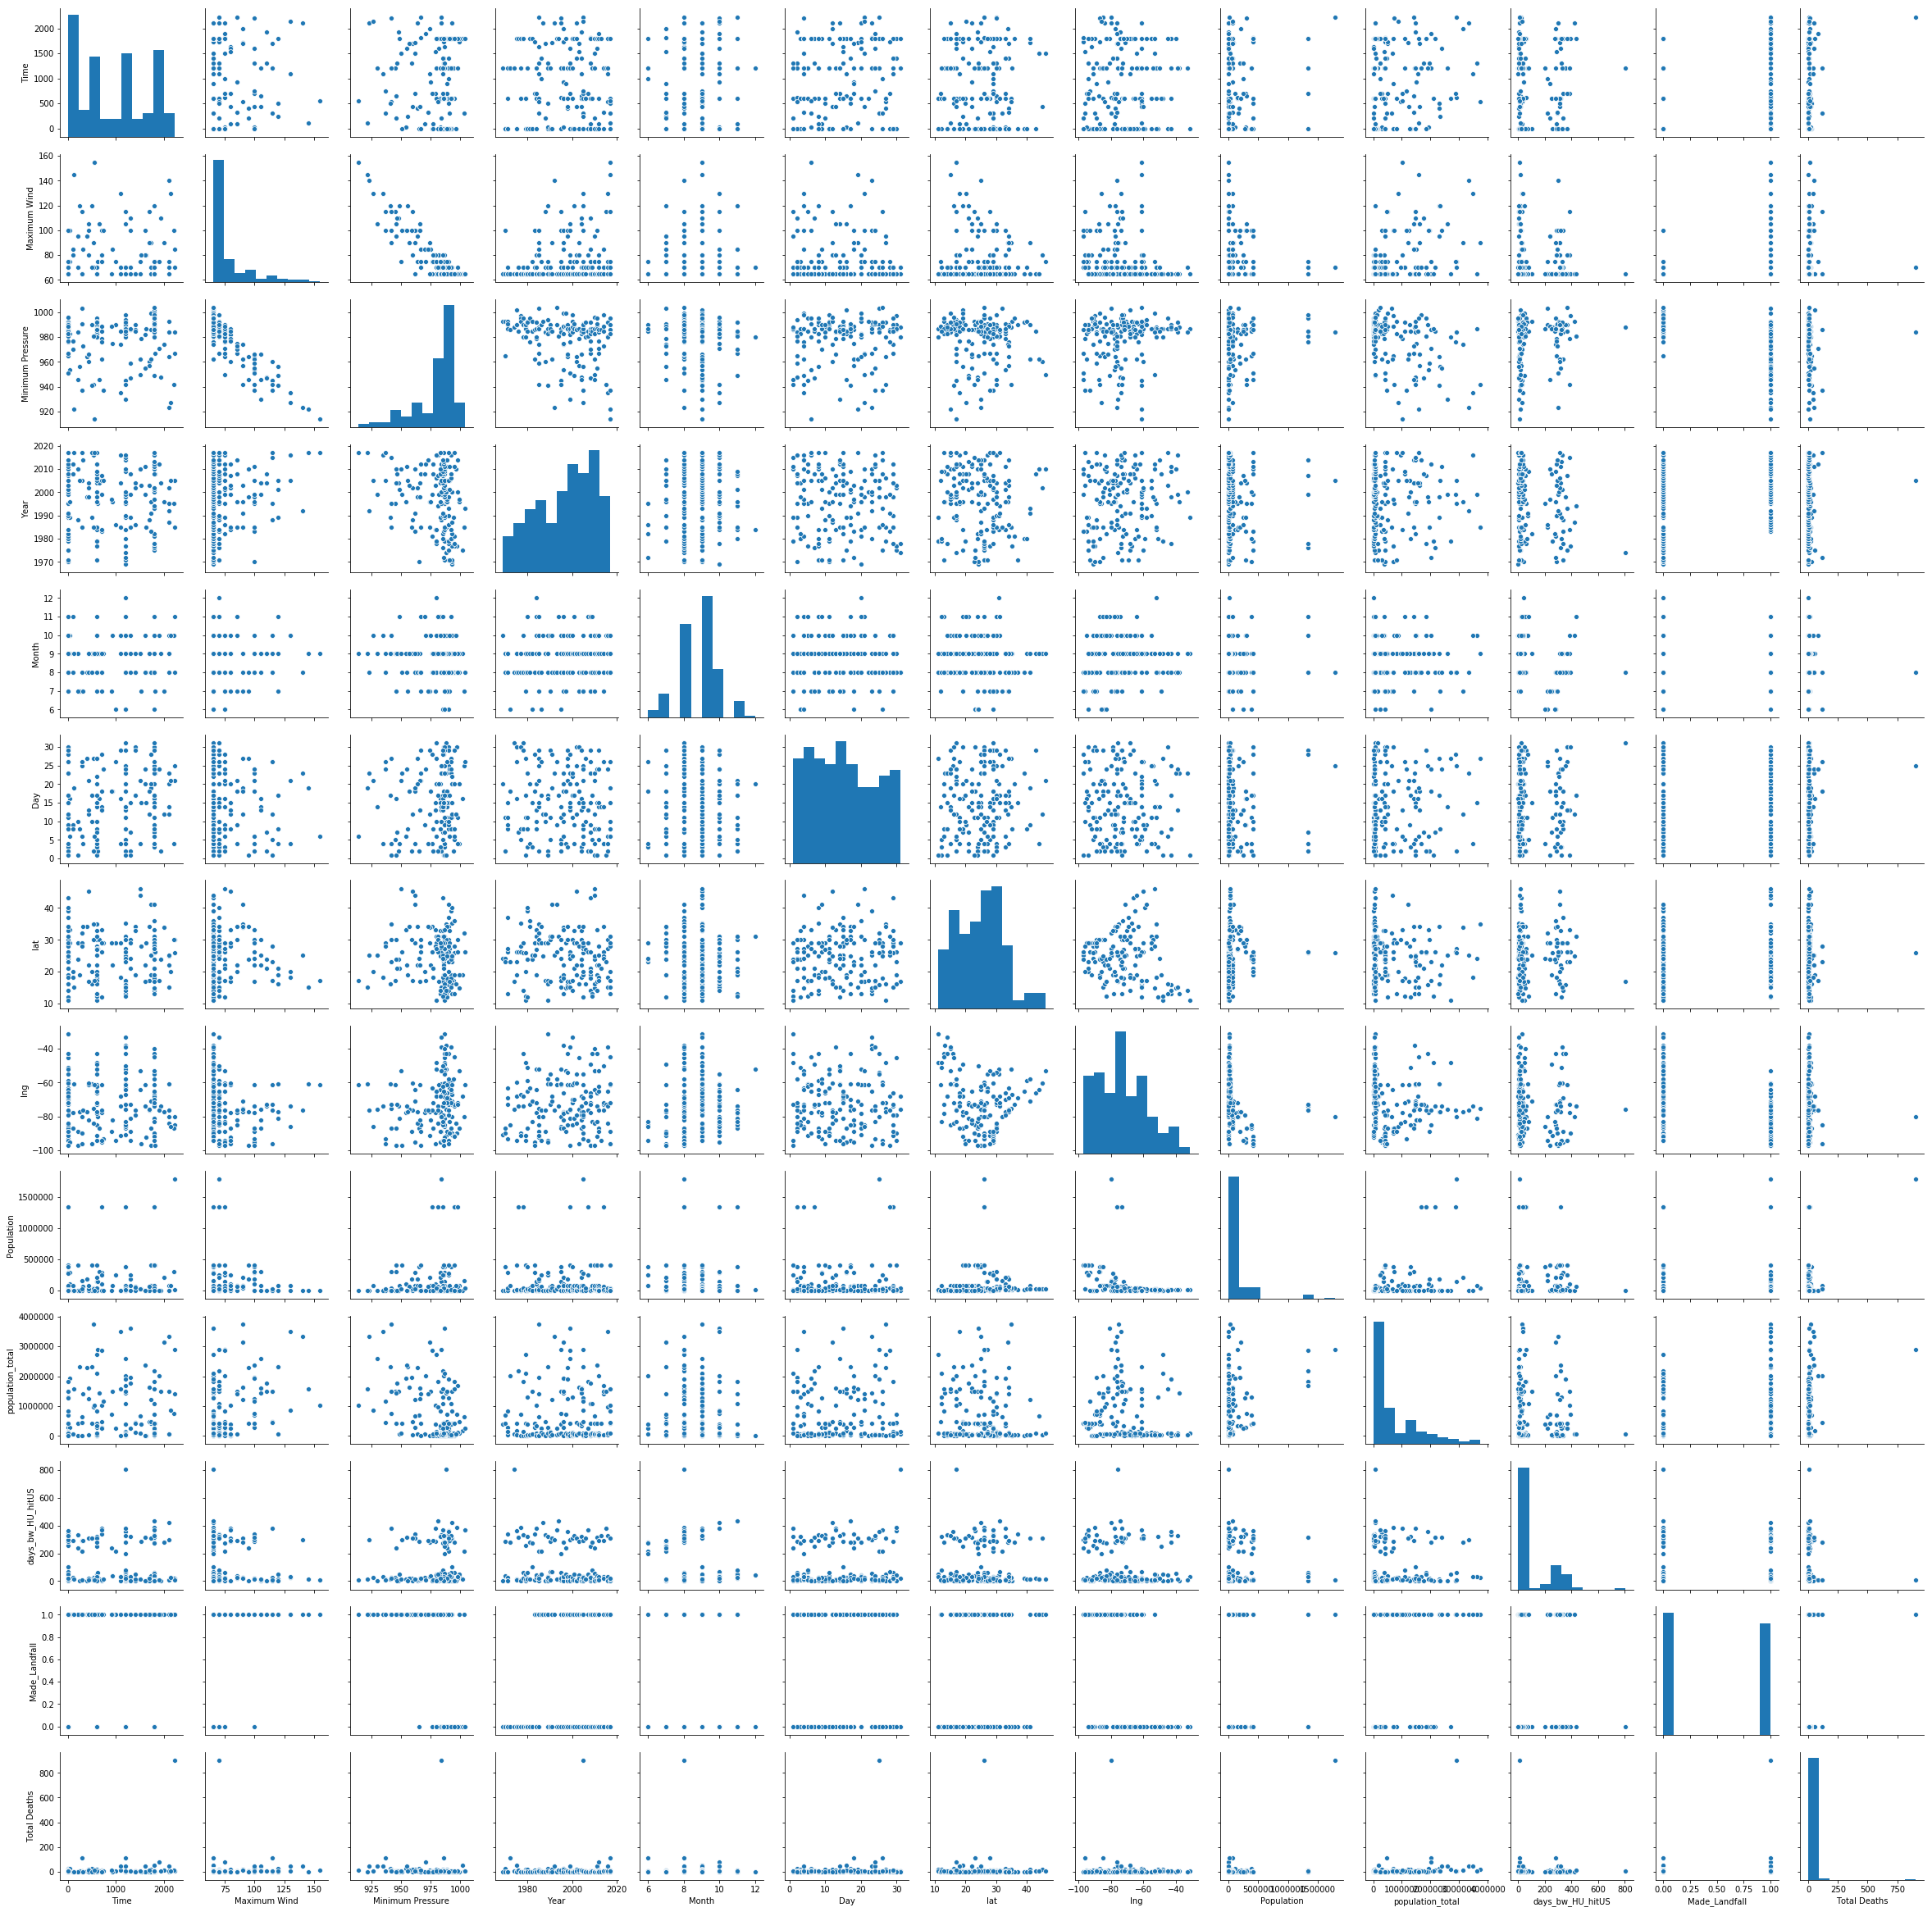

In [110]:
#Pairplot of numerical columns:
sns.pairplot(df_us[col_features_d])

It looks like not a lot of features are linearly related, so collinearity of features is probably not an issue.  Perhaps the outlier (hurricane Katrina) makes the features appear unrelated to each other.  Hurricane Katrina will likely be removed in future modeling.

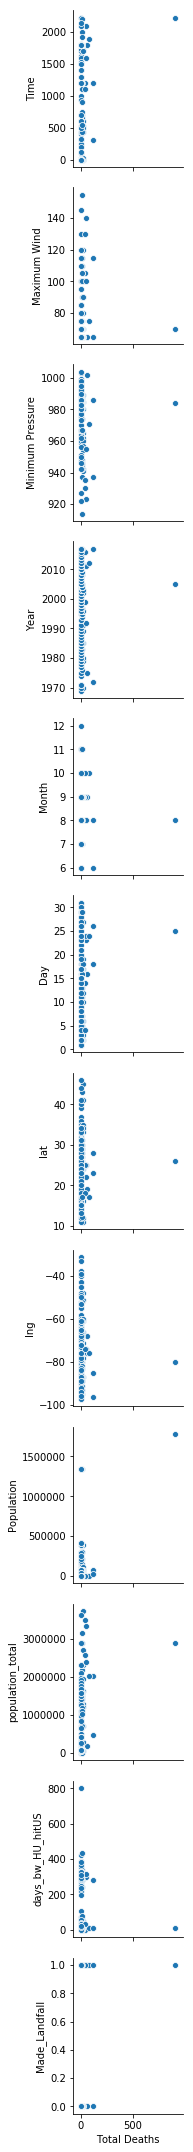

In [111]:
#Pairplot of numerical columns with a focus on how they related to the target variables (Total Deaths):
sns.pairplot(df_us, x_vars = 'Total Deaths', y_vars = col_features)

It looks like Hurricane Katrina is a big outlier.  Katrina might be removed in the future (after the baseline model is built).

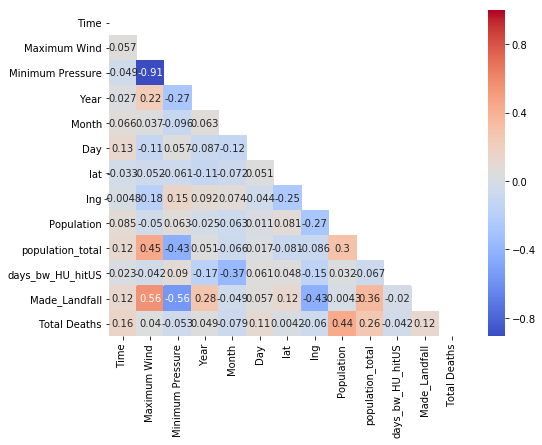

In [112]:
#Looking at the numerical features and how they correlate to 
#each other and the number of deaths (the target variable)
plt.figure(figsize = (8,6))

corr = df_us[col_features_d].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask = mask, cmap = 'coolwarm', annot = True); 

Looking at correlations with magnitudes greater than 0.2:
It looks like:
- Maximum Wind and Year are positively correlated.  Potentially the maximum wind has increased by year due to global climate change.
- Made_Landfall and Year are positively correlated.  It seems that the number of hurricanes to make landfall in the US has increased with time, or the recording of landfall has increased with time.
- Maximum Wind and Made_Landfall are positively correlated.  Perhaps the hurricanes that made landfall had higher maximum wind speeds than the hurricanes that did not make landfall because the first occurence of a storm being categorized as a hurricane was taken for hurricanes that did not make landfall, and this may be a systematic underestimation of maximum wind speed for hurricanes that did not make landfall.
It also looks like:
- Made_Landfall and Longitude are negatively correlated.  Longitude increases while heading east (less negative when heading toward Greenwich, England.  Therefore, as hurricanes head east (away from the US east coast), they less often made landfall (which makes sense because they are moving away from the east coast of the US). 
- Made_Landfall and Minimum Pressure are negatively correlated.  Perhaps when a hurricane makes landfall, the minimum pressure decreases.
- Minimum Pressure and Year are negatively correlated.  It appears that with time, the minimum pressure of hurricanes may be decreasing.  According to sciencing.com, the lower the barometric pressure at the center of the storm (which is typically at the eye of the hurricane), the stronger the hurricane.  It appears that with time, hurricanes have become more intense.  
- Month and days_bw_HU_hitUS are negatively correlated.  This is probably because the number of days between each hurricane season is large, so the lower numbered months such as June (month 6) have high numbers of days between hurricane seasons, and the later months such as October (month 10) have lower numbers of days between hurricanes because they are well into the hurricane season. 

Population and population_total are positively correlated that are potentially collinear because the population at the county nearest the storm at the time point that we are inspecting population could greatly affect the sum of populations of counties that were nearest to all of the storm report time points.

Population and population_total are correlated to Made_Landfall.  Potentially this is because people choose to live in places with an ocean view which unfortunately can be locations where hurricanes would potentially make landfall.
  
Sources: 
http://ww2010.atmos.uiuc.edu/(Gh)/guides/mtr/hurr/stages/cane/pswd.rxml
https://sciencing.com/barometric-pressure-hurricanes-22734.html

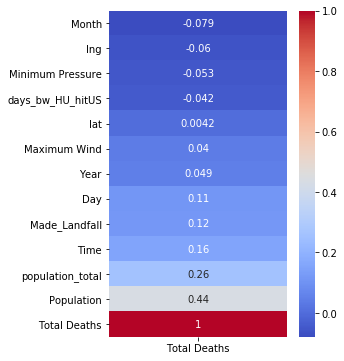

In [113]:
#Looking at the numerical features and how they correlate to the total number of deaths (the target variable):
plt.figure(figsize = (4,6))
sns.heatmap(df_us[col_features_d].corr()[['Total Deaths']].sort_values('Total Deaths'), annot=True, cmap='coolwarm')

It appears that the day of the month, whether the hurricane made landfall, time of the day, population near the hurricane at the timepoint, and the sum of population of counties the hurricane was near/hit during hurricane reporting are positively correlate with total deaths.  It makes sense that total deaths would increase if the hurricane makes landfall and more people live near the location of the hurricane.  The time of day could also affect whether people are prepared and awake enough to protect themselves as well.  The day of the month does not logically seem to correlate with storm fatality though.  The correlations are not very strong, so this might be a concern when modeling.
As month number increases, the total deaths seems to decrease probably because later months like October and November are the months when hurricane season is beginning to end.  Potentially the storms become less intense during the later months in hurricane season.

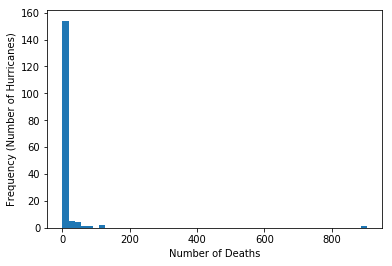

In [114]:
#Inspecting the distribution of Total Deaths:
plt.hist(df_us['Total Deaths'], bins=50)
plt.xlabel('Number of Deaths')
plt.ylabel('Frequency (Number of Hurricanes)');

The distribution of the target variable is not normal, so the data will be power transformed before the model is built.

#### Creating X features dataframe and y target series

In [115]:
#Setting up the features dataframe and the target series:
#Features list:
X = df_us[col_features]
#Target series:
y = df_us['Total Deaths']

#### Train-test-splitting data (into model training sets and testing sets)

In [116]:
#Splitting up the data:
#Using 75% of data for training and 25% of data for testing
#Making sure to shuffle the data since there may be a dependency of hurricane intensity with increasing year
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size = 0.75, 
                                                    test_size = 0.25,
                                                    shuffle = True, 
                                                    random_state=42)

#### Finding the baseline accuracy: Decided baseline would be the average number of fatalities of the train set

In [117]:
#Finding the mean number of fatalities overall:
np.mean(y)

11.672619047619047

In [118]:
#Finding the mean number of fatalities in the train set:
np.mean(y_train)

14.373015873015873

In [119]:
#Finding the mean number of fatalities in the test set:
np.mean(y_test)

3.5714285714285716

Note that the average fatality rate is quite different for the train set and the test set, likely due to outliers (especially Katrina) which could be removed later.

In [120]:
baseline_array = [np.mean(y_train)] * len(y_test)
len(baseline_array)

42

In [121]:
len(y_test)

42

In [122]:
baseline_array[0]

14.373015873015873

In [123]:
#Finding the r2 score if the average number of fatalities of the train set is used as a baseline model to 
#predict test set hurricane fatalities:
r2_score(y_test, baseline_array)

-6.328826704933715

#### Power Transforming the data 

In [124]:
#Instantiating PowerTransformer for X variables:
pt = PowerTransformer()

#Fitting and transforming the train data:
pt.fit(X_train)
X_train_pt = pt.transform(X_train)
#Transforming the test data:
X_test_pt = pt.transform(X_test)

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [125]:
#Instantiating PowerTransformer for y variables:
pt_y = PowerTransformer()

# PowerTransformer requires a matrix/DataFrame, which is why we're using the .to_frame() method on y_train
#Fitting and transforming the train data:
pt_y.fit(y_train.to_frame()) 
y_train_pt = pt_y.transform(y_train.to_frame())
#Transforming the test data:
y_test_pt = pt_y.transform(y_test.to_frame())

### Generating Linear Regression Model of All Features

In [126]:
#Instantiating Linear Regression Model
lr = LinearRegression()

#Fitting the model:
lr.fit(X_train_pt, y_train_pt)

#Generating predictions:
lr_preds = lr.predict(X_test_pt)

#Generating metrics and printing them to see how well the model performed:
print(f'Intercept: {lr.intercept_}')
lr_train_score = lr.score(X_train_pt, y_train_pt)
lr_test_score = lr.score(X_test_pt, y_test_pt)
lr_cv_scores_mean = cross_val_score(lr, X_train_pt, y_train_pt, cv=5).mean()

#Generating and displaying a dataframe with the Beta coefficients:
df_coeffs = pd.DataFrame()
df_coeffs['Features'] = X.columns
df_coeffs['Beta Coefficient'] = lr.coef_[0]
display(df_coeffs)

#Reversing the power transform to get predicted Total Deaths in the original units 
#(to compare with the actual values):
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lr_checking = pt_y.inverse_transform(lr_preds.reshape(-1,1))

#Finding the R2 score and the F1 score after reversing the Power Transform:
lr_rev_test_score = r2_score(y_test, pred_reversed_lr_checking)

#Printing the r2 score if the average number of fatalities of the train set is used as a baseline model to 
#predict test set hurricane fatalities:
print(f'Baseline R2 score (baseline: average train set hurricane fatalities): {r2_score(y_test, baseline_array)}')

#Generating and displaying the model metrics dataframe
df_metrics = pd.DataFrame(columns = ['Model', 'Train Score', 'Test Score', 
                                     'Cross-Validation Score', 'R2 Score of Preds'])
df_metrics.loc[0] = ['LR_AllFeatures_AllData', lr_train_score, lr_test_score, lr_cv_scores_mean, lr_rev_test_score]
df_metrics

#Source:
#https://stackoverflow.com/questions/34398054/ipython-notebook-cell-multiple-outputs

Intercept: [-8.72282138e-09]


,Features,Beta Coefficient
0,Time,0.005973
1,Maximum Wind,-0.030342
2,Minimum Pressure,-0.206187
3,Year,0.028659
4,Month,-0.199958
5,Day,0.015492
6,lat,0.058550
7,lng,0.129804
8,Population,-0.127149
9,population_total,0.291778


Baseline R2 score (baseline: average train set hurricane fatalities): -6.328826704933715


,Model,Train Score,Test Score,Cross-Validation Score,R2 Score of Preds
0,LR_AllFeatures_AllData,0.305486,0.257909,0.059371,0.002454


It appears that the total population of the counties the storm approached/landed on, longitude, and whether the hurricane made landfall affect the model given the higher beta coefficients.  It also looks like lower minimum pressure values, month, and population of the county during the time point when the storm was categorized as a hurricane also significantly affect the model given the corresponding beta coefficients are negative and have high magnitudes.

The R2 scores are all better than the baseline R2 score. Unfortunately the cross-validation score and the R2 score post reversing the power transform are significantly lower than the train and test scores.  The train score and test score are surprisingly pretty similar (even though the average fatality rate for the train set and test set are quite different).  The R2 score decreased significantly after reversing the Power Transform, and it nearly became negative which means the model nearly predicted the total deaths worse than just assuming each hurricane has total fatalities equal to the mean of the train set's total fatalities (approx. 14 fatalities per storm).  Regularization would potentially help to improve the model.  Other models may be appropriate as well.

### Model 2: Using Linear Regression of All Features - Without Outliers

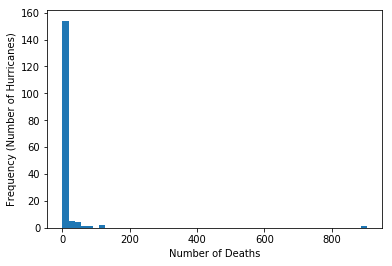

In [127]:
#Inspecting the distribution of Total Deaths:
plt.hist(df_us['Total Deaths'], bins=50)
plt.xlabel('Number of Deaths')
plt.ylabel('Frequency (Number of Hurricanes)');

#### Removing Hurricane Katrina from the dataset since it is a major outlier

In [128]:
#Looking for the index of the row with Hurricane Katrina information:
df_us[df_us['Name'] == 'KATRINA'].index[0]

115

In [129]:
#Removing the Hurricane Katrina row from df_us:
df_us.drop(df_us[df_us['Name'] == 'KATRINA'].index[0], inplace = True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [130]:
#Resetting the index for ease of future dataframe manipulation:
df_us.reset_index(drop = True, inplace = True)

In [131]:
#Checking no Hurricane Katrina row remaining in the dataframe:
df_us[df_us['Name'] == 'KATRINA']

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Year,Month,Day,lat,lng,county_name,state_name,Population,population_total,Total Deaths,US Impact? 1=yes,date_time,time_bw_HU_hitUS,days_bw_HU_hitUS,Made_Landfall


#### Redoing some EDA to see what the data looks like without Hurricane Katrina

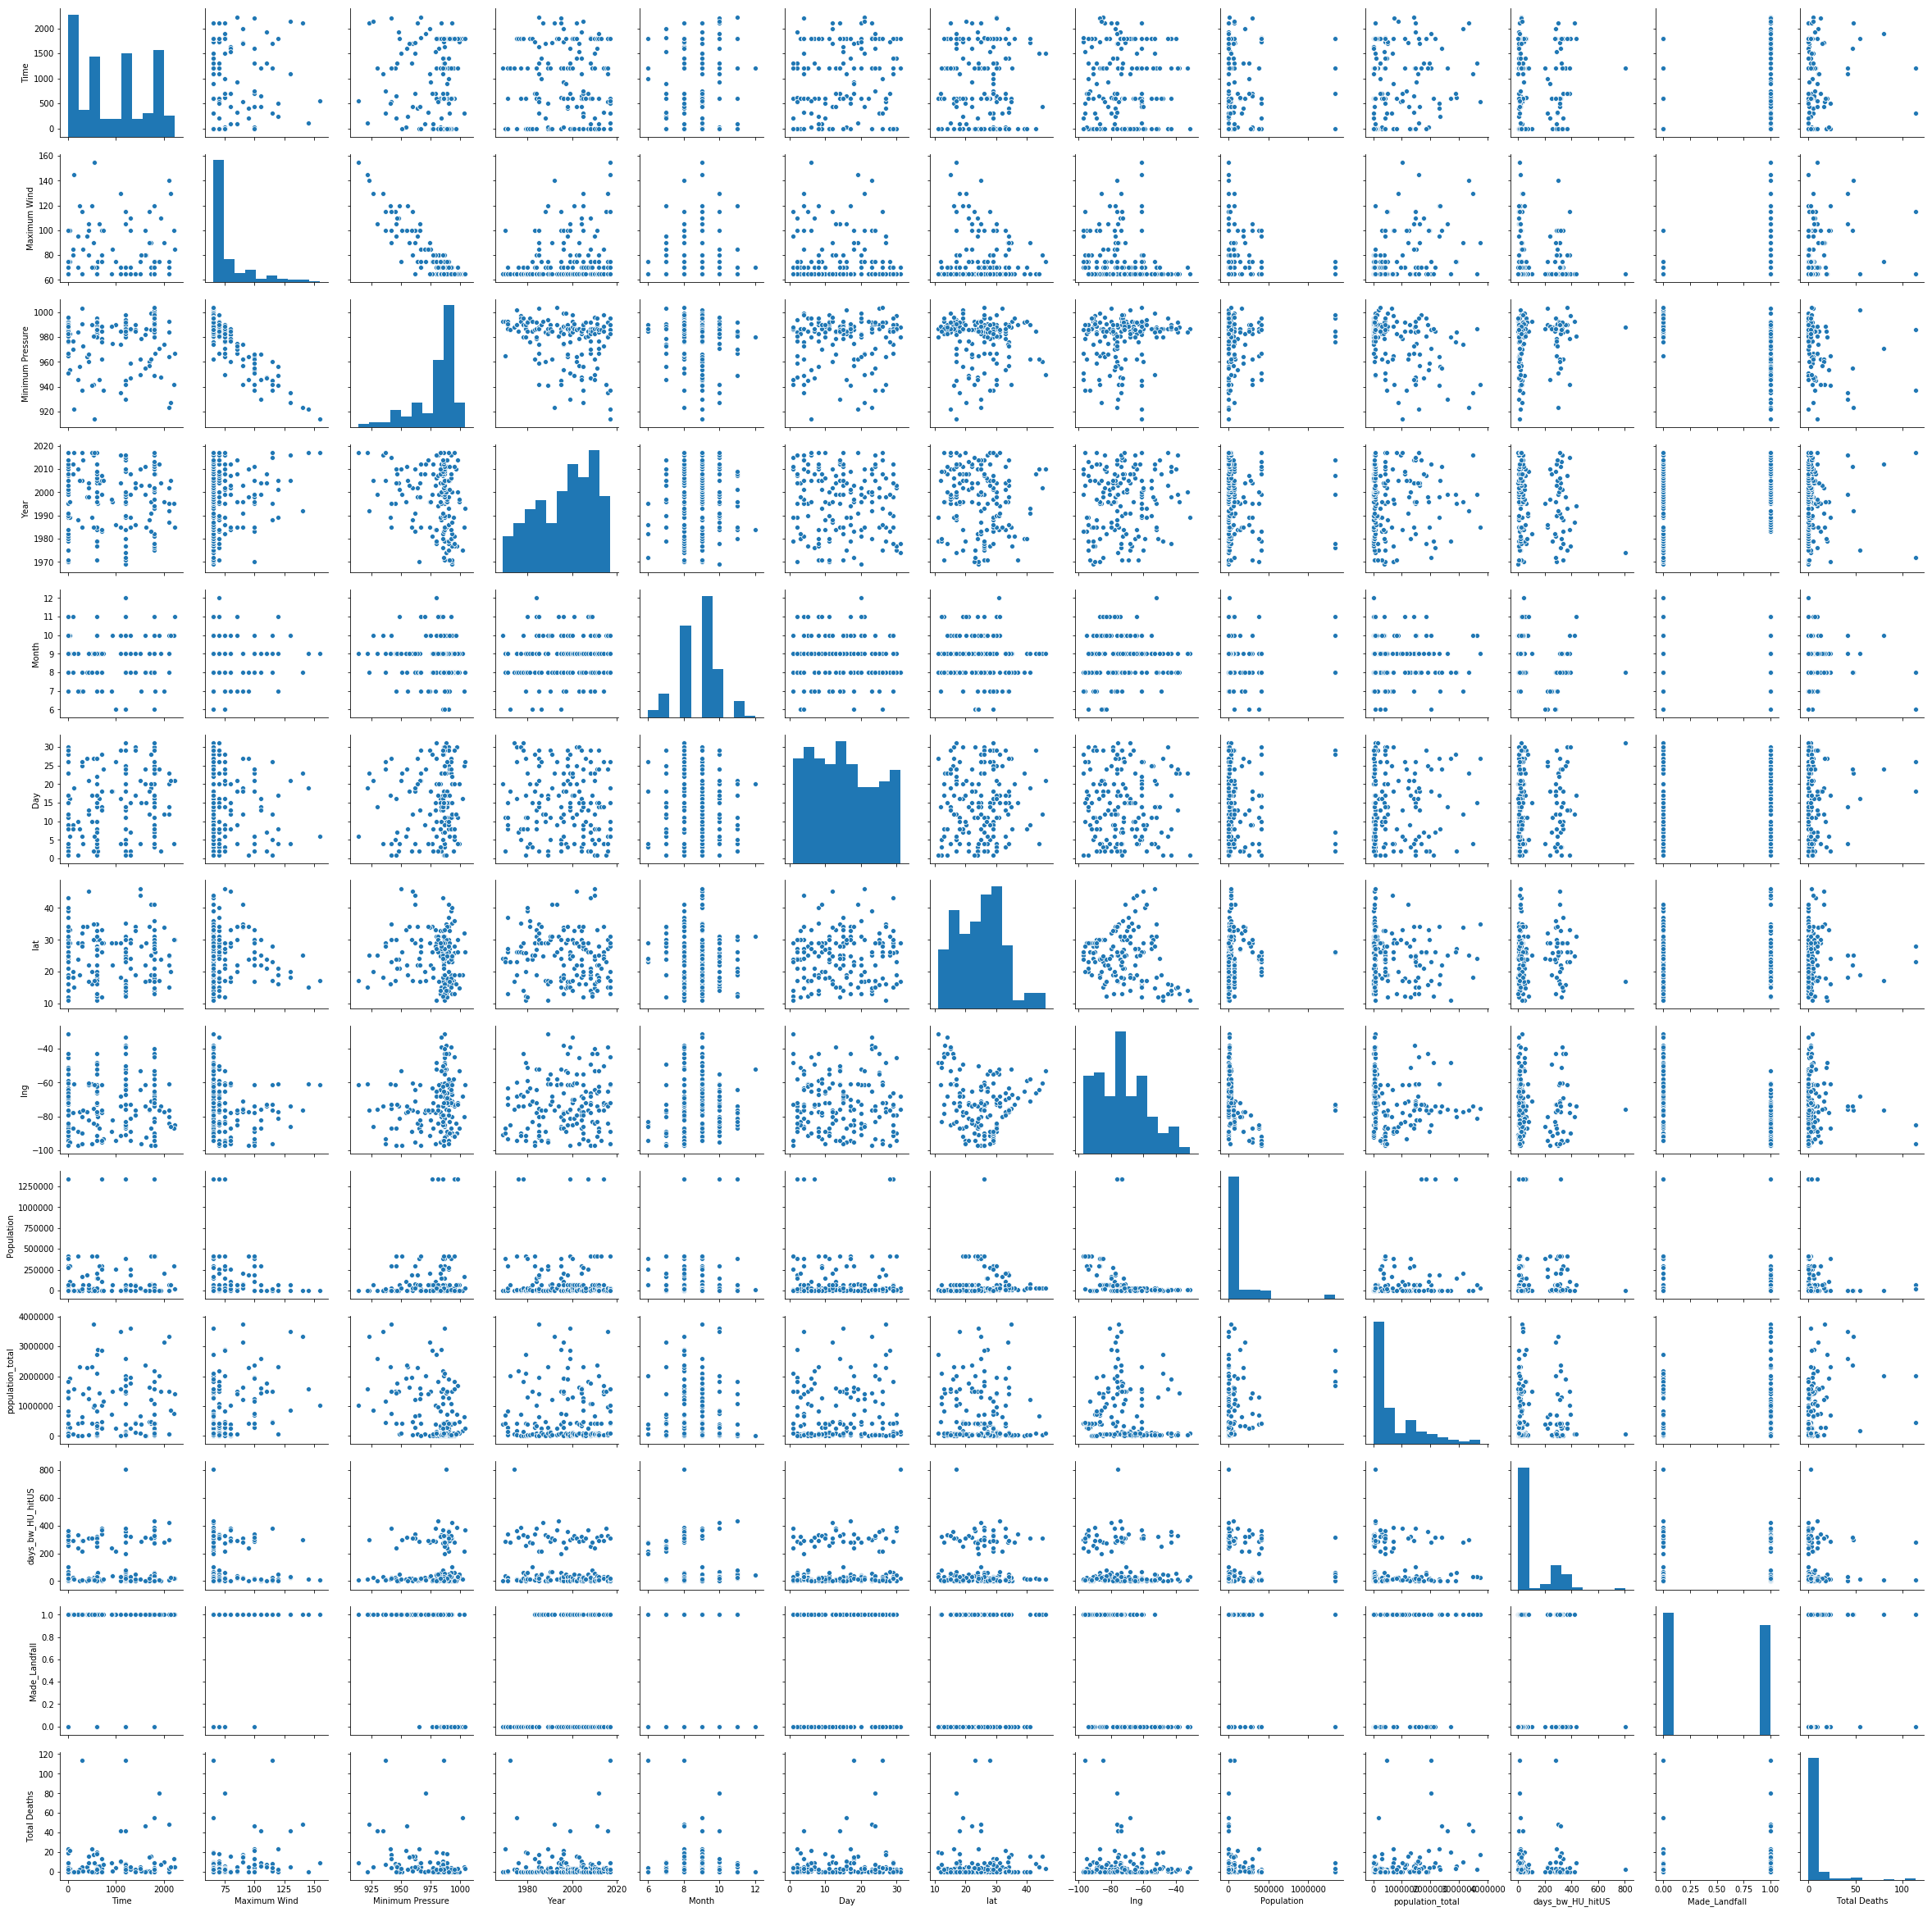

In [132]:
#Inspecting pairplot of numerical columns after Katrina was removed:
sns.pairplot(df_us[col_features_d])

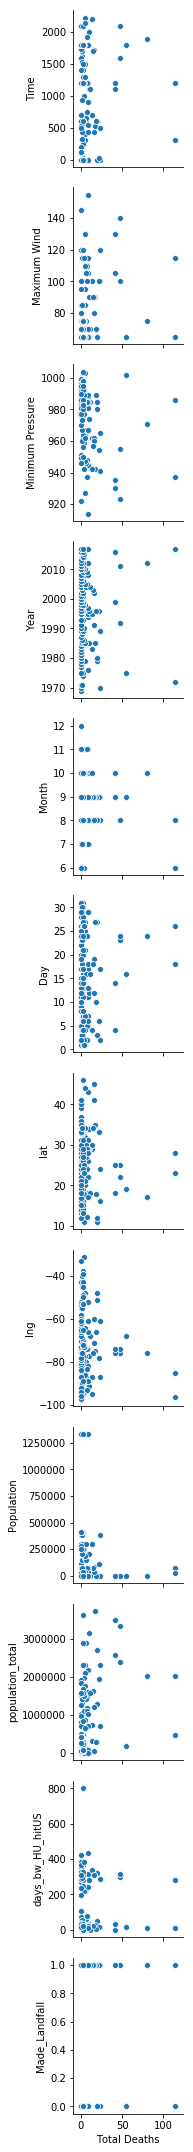

In [133]:
#Pairplot of numerical columns with a focus on how they related to the target variables (Total Deaths):
sns.pairplot(df_us, x_vars = 'Total Deaths', y_vars = col_features)

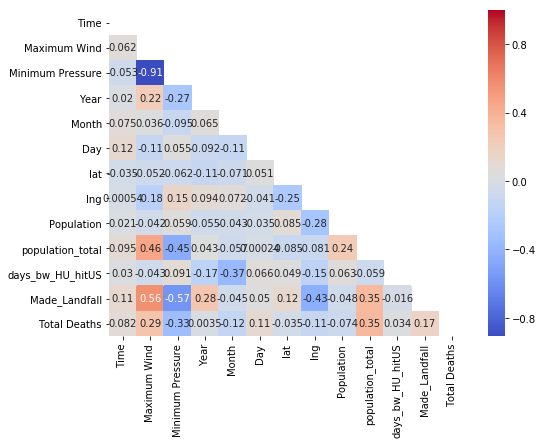

In [134]:
#Looking at the numerical features and how they correlate to 
#each other and the number of deaths (the target variable)
plt.figure(figsize = (8,6))

corr = df_us[col_features_d].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask = mask, cmap = 'coolwarm', annot = True);

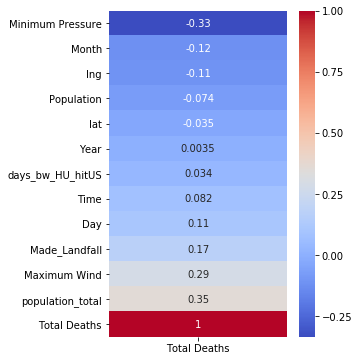

In [135]:
#Looking at the numerical features and how they correlate to the total number of deaths (the target variable):
plt.figure(figsize = (4,6))
sns.heatmap(df_us[col_features_d].corr()[['Total Deaths']].sort_values('Total Deaths'), annot=True, cmap='coolwarm')

Now that the Hurricane Katrina outlier has been removed, some collinearity is more apparent. It looks like minimum pressure is strongly linearly related to maximum wind.  It still looks like features are not strongly linearly related to the target variable, and there is heteroscedasticity of error, so the PowerTransformer may have helped to better fulfill the assumptions of multiple linear regression, but it may help to try other models less dependent on those assumptions such as Random Forest after this.
Note that there are stronger correlations to the target variable now.  It looks like the total population of counties near the hurricane, maximum wind, and whether the hurricane made landfall are quite correlated with total deaths.  Minimum pressure is quite negatively correlated with total deaths as well (lower minimum pressures seem to be correlated with higher maximum wind which can increase hurricane intensity).

#### Creating X features dataframe and y target series again

In [136]:
#Setting up the features dataframe and the target series:
#Features list:
X = df_us[col_features]
#Target series:
y = df_us['Total Deaths']

#### Train-test-splitting data again

In [137]:
#Splitting up the data:
#Using 75% of data for training and 25% of data for testing
#Making sure to shuffle the data since there may be a dependency of hurricane intensity with increasing year
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size = 0.75, 
                                                    test_size = 0.25,
                                                    shuffle = True, #stratify = y (tried this but got error)
                                                    random_state=42)

#### Finding the baseline accuracy (after removing Katrina): Decided baseline would be the average number of fatalities of the train set

In [138]:
#Finding the mean number of fatalities overall:
np.mean(y)

6.3293413173652695

In [139]:
#Finding the mean number of fatalities in the train set:
np.mean(y_train)

7.04

In [140]:
#Finding the mean number of fatalities in the test set:
np.mean(y_test)

4.214285714285714

Note that the average fatality rate is quite different for the train set and the test set, even after removing Katrina (likely due to other outliers which could be removed later, depending on whether it is determined that they are appropriate to be removed).

In [141]:
baseline_array = [np.mean(y_train)] * len(y_test)
len(baseline_array)

42

In [142]:
len(y_test)

42

In [143]:
baseline_array[0]

7.04

In [144]:
#Finding the r2 score if the average number of fatalities of the train set is used as a baseline model to 
#predict test set hurricane fatalities:
r2_score(y_test, baseline_array)

-0.14435878608984432

Note that the baseline accuracy increased significantly, but it is still below 0.

#### Power Transforming the data again

In [145]:
#Instantiating PowerTransformer for X variables:
pt = PowerTransformer()

#Fitting and transforming the train data:
pt.fit(X_train)
X_train_pt = pt.transform(X_train)
#Transforming the test data:
X_test_pt = pt.transform(X_test)

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [146]:
#Instantiating PowerTransformer for y variables:
pt_y = PowerTransformer()

# PowerTransformer requires a matrix/DataFrame, which is why we're using the .to_frame() method on y_train
#Fitting and transforming the train data:
pt_y.fit(y_train.to_frame()) 
y_train_pt = pt_y.transform(y_train.to_frame())
#Transforming the test data:
y_test_pt = pt_y.transform(y_test.to_frame())

#### Modeling the data using linear regression

In [147]:
#Instantiating Linear Regression Model
lr = LinearRegression()

#Fitting the model:
lr.fit(X_train_pt, y_train_pt)

#Generating predictions:
lr_preds = lr.predict(X_test_pt)

#Generating metrics and printing them to see how well the model performed:
print(f'Intercept: {lr.intercept_}')
lr_train_score_1 = lr.score(X_train_pt, y_train_pt)
lr_test_score_1 = lr.score(X_test_pt, y_test_pt)
lr_cv_scores_mean_1 = cross_val_score(lr, X_train_pt, y_train_pt, cv=5).mean()

#Generating and displaying a dataframe with the Beta coefficients:
df_coeffs = pd.DataFrame()
df_coeffs['Features'] = X.columns
df_coeffs['Beta Coefficient'] = lr.coef_[0]
display(df_coeffs)

#Reversing the power transform to get predicted Total Deaths in the original units 
#(to compare with the actual values):
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lr_checking_1 = pt_y.inverse_transform(lr_preds.reshape(-1,1))

#Finding the R2 score after reversing the Power Transform:
lr_rev_test_score_1 = r2_score(y_test, pred_reversed_lr_checking_1)

#Printing the r2 score if the average number of fatalities of the train set is used as a baseline model to 
#predict test set hurricane fatalities:
print(f'Baseline R2 score (baseline: average train set hurricane fatalities): {r2_score(y_test, baseline_array)}')

#Generating and displaying the model metrics dataframe
df_metrics = pd.DataFrame(columns = ['Model', 'Train Score', 'Test Score', 
                                     'Cross-Validation Score', 'R2 Score of Preds'])
df_metrics.loc[0] = ['LR_AllFeatures_AllData', lr_train_score, lr_test_score, lr_cv_scores_mean, lr_rev_test_score]
df_metrics.loc[1] = ['LR_AllFeatures_NoKatrina', lr_train_score_1, lr_test_score_1, 
                     lr_cv_scores_mean_1, lr_rev_test_score_1]
df_metrics

#Source:
#https://stackoverflow.com/questions/34398054/ipython-notebook-cell-multiple-outputs

Intercept: [-3.95828133e-08]


,Features,Beta Coefficient
0,Time,0.035188
1,Maximum Wind,-0.071036
2,Minimum Pressure,-0.247700
3,Year,0.012645
4,Month,-0.182370
5,Day,0.040524
6,lat,0.076303
7,lng,0.119179
8,Population,-0.177011
9,population_total,0.355772


Baseline R2 score (baseline: average train set hurricane fatalities): -0.14435878608984432


,Model,Train Score,Test Score,Cross-Validation Score,R2 Score of Preds
0,LR_AllFeatures_AllData,0.305486,0.257909,0.059371,0.002454
1,LR_AllFeatures_NoKatrina,0.333031,0.167197,0.129873,0.080535


It appears that the total population of the counties the storm approached/landed on, longitude, and whether the hurricane made landfall affect the model given the higher beta coefficients.  It also looks like lower minimum pressure values, month, and population of the county during the time point when the storm was categorized as a hurricane also significantly affect the model given the corresponding beta coefficients are negative and have high magnitudes.

The train score increased slightly, but the test score decreased significantly. The cross-validation score increased, and the post reverse-transform R2 score increased (positive, so better than assuming total deaths is the mean of the y_train total deaths which is approx. 7 deaths).  It appears that Population and population_total are collinear, so the next model will be built without Population since population_total is more correlated to total deaths, and it is the sum of county populations that were near the hurricane at different time points.

### Model 3: Using Linear Regression of All Features - Without Outlier: Hurricane Katrina and Without Population (at One Time Point) Column

#### Recreating list of columns want to inspect as features:

In [148]:
#Creating col_features without the Population column label:
col_features = ['Time',  'Maximum Wind', 'Minimum Pressure', 'Year', 'Month', 'Day', 
                'lat', 'lng', 'population_total',
                'days_bw_HU_hitUS', 'Made_Landfall']

#### Creating X features dataframe and y target series again

In [149]:
#Setting up the features dataframe and the target series:
#Features list:
X = df_us[col_features]
#Target series:
y = df_us['Total Deaths']

#### Train-test-splitting data again

In [150]:
#Splitting up the data:
#Using 75% of data for training and 25% of data for testing
#Making sure to shuffle the data since there may be a dependency of hurricane intensity with increasing year
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size = 0.75, 
                                                    test_size = 0.25,
                                                    shuffle = True, #stratify = y (tried this but got error)
                                                    random_state=42)

#### Power Transforming the data again

In [151]:
#Instantiating PowerTransformer for X variables:
pt = PowerTransformer()

#Fitting and transforming the train data:
pt.fit(X_train)
X_train_pt = pt.transform(X_train)
#Transforming the test data:
X_test_pt = pt.transform(X_test)

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [152]:
#Instantiating PowerTransformer for y variables:
pt_y = PowerTransformer()

# PowerTransformer requires a matrix/DataFrame, which is why we're using the .to_frame() method on y_train
#Fitting and transforming the train data:
pt_y.fit(y_train.to_frame()) 
y_train_pt = pt_y.transform(y_train.to_frame())
#Transforming the test data:
y_test_pt = pt_y.transform(y_test.to_frame())

#### Modeling the data using linear regression

In [153]:
#Instantiating Linear Regression Model
lr = LinearRegression()

#Fitting the model:
lr.fit(X_train_pt, y_train_pt)

#Generating predictions:
lr_preds = lr.predict(X_test_pt)

#Generating metrics and printing them to see how well the model performed:
print(f'Intercept: {lr.intercept_}')
lr_train_score_2 = lr.score(X_train_pt, y_train_pt)
lr_test_score_2 = lr.score(X_test_pt, y_test_pt)
lr_cv_scores_mean_2 = cross_val_score(lr, X_train_pt, y_train_pt, cv=5).mean()

#Generating and displaying a dataframe with the Beta coefficients:
df_coeffs = pd.DataFrame()
df_coeffs['Features'] = X.columns
df_coeffs['Beta Coefficient'] = lr.coef_[0]
display(df_coeffs)

#Reversing the power transform to get predicted Total Deaths in the original units 
#(to compare with the actual values):
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lr_checking_2 = pt_y.inverse_transform(lr_preds.reshape(-1,1))

#Finding the R2 score after reversing the Power Transform:
lr_rev_test_score_2 = r2_score(y_test, pred_reversed_lr_checking_2)

#Printing the r2 score if the average number of fatalities of the train set is used as a baseline model to 
#predict test set hurricane fatalities:
print(f'Baseline R2 score (baseline: average train set hurricane fatalities): {r2_score(y_test, baseline_array)}')

#Generating and displaying the model metrics dataframe
df_metrics = pd.DataFrame(columns = ['Model', 'Train Score', 'Test Score', 
                                     'Cross-Validation Score', 'R2 Score of Preds'])
df_metrics.loc[0] = ['LR_AllFeatures_AllData', lr_train_score, lr_test_score, lr_cv_scores_mean, lr_rev_test_score]
df_metrics.loc[1] = ['LR_AllFeatures_NoKatrina', lr_train_score_1, lr_test_score_1, 
                     lr_cv_scores_mean_1, lr_rev_test_score_1]
df_metrics.loc[2] = ['LR_NoKatrinaNoPopulationAtOneTimePt', lr_train_score_2, lr_test_score_2, 
                     lr_cv_scores_mean_2, lr_rev_test_score_2]

df_metrics

#Source:
#https://stackoverflow.com/questions/34398054/ipython-notebook-cell-multiple-outputs

Intercept: [-3.37967899e-08]


,Features,Beta Coefficient
0,Time,0.033739
1,Maximum Wind,-0.060652
2,Minimum Pressure,-0.248232
3,Year,-0.011271
4,Month,-0.176729
5,Day,0.039260
6,lat,-0.001141
7,lng,0.165760
8,population_total,0.315895
9,days_bw_HU_hitUS,-0.000642


Baseline R2 score (baseline: average train set hurricane fatalities): -0.14435878608984432


,Model,Train Score,Test Score,Cross-Validation Score,R2 Score of Preds
0,LR_AllFeatures_AllData,0.305486,0.257909,0.059371,0.002454
1,LR_AllFeatures_NoKatrina,0.333031,0.167197,0.129873,0.080535
2,LR_NoKatrinaNoPopulationAtOneTimePt,0.312377,0.176862,0.141273,0.029977


It looks like the train and test scores are closer to each other, and the cross-validation score improved, but the R2 score decreased after removing the Population (at one time point) column.  It would make sense to move forward with a different type of model than linear regression because the data does not fulfill the assumptions needed to properly perform multiple linear regression (for example, features do not all have strongly linear relationships with the target variable), and its performance does not seem to be optimal for this scenario.

### Model 4: Using K-Nearest Neighbor Regressor and GridSearchCV

In [154]:
#Instantiating StandardScaler for X variables (not scaling y-values when using KNN):
ss = StandardScaler()

#Fitting and transforming the train data:
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
#Transforming the test data:
X_test_ss = ss.transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [155]:
#Instantiating Model:
knn = KNeighborsRegressor()

#Setting up the parameters that will be inspected during GridSearchCV:
knn_params = {
    'n_neighbors': [2, 3, 4, 5, 10, 14], #looking at various numbers of neighbors
}

#Doing the gridsearch:
gs = GridSearchCV(knn, param_grid = knn_params, cv=3)

#Fitting the model:
gs.fit(X_train_ss, y_train)

#Generating predictions:
gs_preds = gs.predict(X_test_ss)

#Finding the R2 score after reversing the Power Transform:
knn_rev_test_score_3 = r2_score(y_test, gs_preds)

#Generating metrics and printing them to see how well the model performed:
print(gs.best_params_)
model_train_score_3 = gs.score(X_train_ss, y_train)
model_test_score_3 = gs.score(X_test_ss, y_test)
model_cv_score_3 = gs.best_score_

#Printing the r2 score if the average number of fatalities of the train set is used as a baseline model to 
#predict test set hurricane fatalities:
print(f'Baseline R2 score (baseline: average train set hurricane fatalities): {r2_score(y_test, baseline_array)}')

#Generating and displaying the model metrics dataframe
df_metrics = pd.DataFrame(columns = ['Model', 'Train Score', 'Test Score', 
                                     'Cross-Validation Score', 'R2 Score of Preds'])
df_metrics.loc[0] = ['LR_AllFeatures_AllData', lr_train_score, lr_test_score, lr_cv_scores_mean, lr_rev_test_score]
df_metrics.loc[1] = ['LR_AllFeatures_NoKatrina', lr_train_score_1, lr_test_score_1, 
                     lr_cv_scores_mean_1, lr_rev_test_score_1]
df_metrics.loc[2] = ['LR_NoKatrinaNoPopulationAtOneTimePt', lr_train_score_2, lr_test_score_2, 
                     lr_cv_scores_mean_2, lr_rev_test_score_2]
df_metrics.loc[3] = ['KNN Regressor (Using GridSearchCV)', model_train_score_3, model_test_score_3, 
                     model_cv_score_3, knn_rev_test_score_3]

#Looking at the metrics df:
df_metrics

{'n_neighbors': 14}
Baseline R2 score (baseline: average train set hurricane fatalities): -0.14435878608984432


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,Model,Train Score,Test Score,Cross-Validation Score,R2 Score of Preds
0,LR_AllFeatures_AllData,0.305486,0.257909,0.059371,0.002454
1,LR_AllFeatures_NoKatrina,0.333031,0.167197,0.129873,0.080535
2,LR_NoKatrinaNoPopulationAtOneTimePt,0.312377,0.176862,0.141273,0.029977
3,KNN Regressor (Using GridSearchCV),0.144446,0.073921,-0.183934,0.073921


The train score and test score and cross-validation scores decreased significantly (the cross-validation score is lower than the baseline R2 score, so this model did not perform better than the baseline model).  The model train score is significantly higher than the model test score, so the model is still quite overfit.  The R2 score of predictions compared to the actual values increased quite a bit.  Decision trees will be used next to see if a better model can be found. 

### Model 5: Using Decision Tree Regressor and GridSearchCV

In [156]:
#Instantiating Model:
dt = DecisionTreeRegressor(random_state=42)

#Setting up the parameters that will be inspected during GridSearchCV:
dt_params = {
    #'n_estimators': [10, 50, 100], #looking at 10, 50, or 100 trees
    'max_depth': [None, 3, 4, 5],  #looking at max depth (nodes) of none, 3, 4, or 5
    'max_features': ['auto', 4, 5], #looking at max features of auto (all features), 4, and 5 features
    'min_samples_split':[2, 4, 6] #looking at 2, 4, or 6 minimum samples needed to perform a split
}

#Doing the gridsearch:
gs = GridSearchCV(dt, param_grid = dt_params, cv=3)

#Fitting the model (note not using scaled data for decision tree model):
gs.fit(X_train, y_train)

#Generating predictions:
gs_preds = gs.predict(X_test)

#Generating metrics and printing them to see how well the model performed:
print(gs.best_params_)
model_train_score_4 = gs.score(X_train, y_train)
model_test_score_4 = gs.score(X_test, y_test)
model_cv_score_4 = gs.best_score_
model_r2_score_4 = r2_score(y_test, gs_preds)

#Printing the r2 score if the average number of fatalities of the train set is used as a baseline model to 
#predict test set hurricane fatalities:
print(f'Baseline R2 score (baseline: average train set hurricane fatalities): {r2_score(y_test, baseline_array)}')

#Generating and displaying the model metrics dataframe
df_metrics = pd.DataFrame(columns = ['Model', 'Train Score', 'Test Score', 
                                     'Cross-Validation Score', 'R2 Score of Preds'])
df_metrics.loc[0] = ['LR_AllFeatures_AllData', lr_train_score, lr_test_score, lr_cv_scores_mean, lr_rev_test_score]
df_metrics.loc[1] = ['LR_AllFeatures_NoKatrina', lr_train_score_1, lr_test_score_1, 
                     lr_cv_scores_mean_1, lr_rev_test_score_1]
df_metrics.loc[2] = ['LR_NoKatrinaNoPopulationAtOneTimePt', lr_train_score_2, lr_test_score_2, 
                     lr_cv_scores_mean_2, lr_rev_test_score_2]
df_metrics.loc[3] = ['KNN Regressor (Using GridSearchCV)', model_train_score_3, model_test_score_3, 
                     model_cv_score_3, knn_rev_test_score_3]
df_metrics.loc[4] = ['Decision Tree (Using GridSearchCV)', model_train_score_4, model_test_score_4, 
                     model_cv_score_4, model_r2_score_4]

#Looking at the metrics df:
df_metrics

{'max_depth': 4, 'max_features': 'auto', 'min_samples_split': 4}
Baseline R2 score (baseline: average train set hurricane fatalities): -0.14435878608984432


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,Model,Train Score,Test Score,Cross-Validation Score,R2 Score of Preds
0,LR_AllFeatures_AllData,0.305486,0.257909,0.059371,0.002454
1,LR_AllFeatures_NoKatrina,0.333031,0.167197,0.129873,0.080535
2,LR_NoKatrinaNoPopulationAtOneTimePt,0.312377,0.176862,0.141273,0.029977
3,KNN Regressor (Using GridSearchCV),0.144446,0.073921,-0.183934,0.073921
4,Decision Tree (Using GridSearchCV),0.907366,0.452629,-1.175827,0.452629


The model is overfit because the train score is significantly higher than the test score (and the R2 score of the predictions), and the cross-validation score is quite poor (less than the baseline R2 score, meaning this model performs worse than the baseline model).  Tree bagging will be tried next to reduce model overfitting (variance) and to see if model performance can be improved.

### Model 6: Using Decision Tree Bagging and GridSearchCV

In [157]:
#Instantiating models:
#BaggingRegressor = BaggingRegressor()
#dt = DecisionTreeRegressor()

#Setting up the parameters that will be inspected during GridSearchCV:
params = {
    'n_estimators': [10, 50, 100], #looking at 10, 50, or 100 trees
    'base_estimator__max_depth': [None, 3, 4, 5],  #looking at max depth (nodes) of none, 3, 4, or 5
    'base_estimator__max_features': ['auto', 4, 5], #looking at max features of auto (all features), 4, and 5 features
    'base_estimator__min_samples_split':[2, 4, 6] #looking at 2, 4, or 6 minimum samples needed to perform a split
}

#Instantiating the gridsearch:
gs = GridSearchCV(BaggingRegressor(DecisionTreeRegressor(random_state = 42)), param_grid = params, cv=3)                    
    
#Fitting the model:
gs.fit(X_train, y_train)

#Generating predictions:
gs_preds = gs.predict(X_test)

#Generating metrics and printing them to see how well the model performed:
print(gs.best_params_)
model_train_score_5 = gs.score(X_train, y_train)
model_test_score_5 = gs.score(X_test, y_test)
model_cv_score_5 = gs.best_score_
model_r2_score_5 = r2_score(y_test, gs_preds)

#Printing the r2 score if the average number of fatalities of the train set is used as a baseline model to 
#predict test set hurricane fatalities:
print(f'Baseline R2 score (baseline: average train set hurricane fatalities): {r2_score(y_test, baseline_array)}')

#Generating and displaying the model metrics dataframe
df_metrics = pd.DataFrame(columns = ['Model', 'Train Score', 'Test Score', 
                                     'Cross-Validation Score', 'R2 Score of Preds'])
df_metrics.loc[0] = ['LR_AllFeatures_AllData', lr_train_score, lr_test_score, lr_cv_scores_mean, lr_rev_test_score]
df_metrics.loc[1] = ['LR_AllFeatures_NoKatrina', lr_train_score_1, lr_test_score_1, 
                     lr_cv_scores_mean_1, lr_rev_test_score_1]
df_metrics.loc[2] = ['LR_NoKatrinaNoPopulationAtOneTimePt', lr_train_score_2, lr_test_score_2, 
                     lr_cv_scores_mean_2, lr_rev_test_score_2]
df_metrics.loc[3] = ['KNN Regressor (Using GridSearchCV)', model_train_score_3, model_test_score_3, 
                     model_cv_score_3, knn_rev_test_score_3]
df_metrics.loc[4] = ['Decision Tree (Using GridSearchCV)', model_train_score_4, model_test_score_4, 
                     model_cv_score_4, model_r2_score_4]
df_metrics.loc[5] = ['Bagged Decision Trees (Using GridSearchCV)', model_train_score_5, model_test_score_5, 
                     model_cv_score_5, model_r2_score_5]

#Looking at the metrics df:
df_metrics

#Source:
#https://stackoverflow.com/questions/47570307/tuning-parameters-of-the-classifier-used-by-baggingclassifier

{'base_estimator__max_depth': 4, 'base_estimator__max_features': 4, 'base_estimator__min_samples_split': 2, 'n_estimators': 10}
Baseline R2 score (baseline: average train set hurricane fatalities): -0.14435878608984432


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,Model,Train Score,Test Score,Cross-Validation Score,R2 Score of Preds
0,LR_AllFeatures_AllData,0.305486,0.257909,0.059371,0.002454
1,LR_AllFeatures_NoKatrina,0.333031,0.167197,0.129873,0.080535
2,LR_NoKatrinaNoPopulationAtOneTimePt,0.312377,0.176862,0.141273,0.029977
3,KNN Regressor (Using GridSearchCV),0.144446,0.073921,-0.183934,0.073921
4,Decision Tree (Using GridSearchCV),0.907366,0.452629,-1.175827,0.452629
5,Bagged Decision Trees (Using GridSearchCV),0.815201,0.081431,-0.357224,0.081431


The model is still quite overfit because the train score is significantly higher than the test score (and cross-validation and R2 score of the predictions).  The cross-validation score is lower than the baseline R2 score, so it performs worse than the baseline model.  Random forest regression will be tried next to see if model variance can be reduced and if model performance can be improved.

### Model 7: Using Random Forest Regressor and GridSearchCV

In [158]:
#Instantiating Model:
rf = RandomForestRegressor(random_state=42)

#Setting up the parameters that will be inspected during GridSearchCV:
rf_params = {
    'n_estimators': [10, 20, 50, 100], #looking at various numbers of trees
    'max_depth': [None, 3, 4, 5],  #looking at max depth (nodes) of none, 3, 4, or 5
    'max_features': ['auto', 4, 5], #looking at max features of auto (all features), 4, and 5 features
    'min_samples_split':[2, 4, 6] #looking at 2, 4, or 6 minimum samples needed to perform a split
}

#Doing the gridsearch:
gs = GridSearchCV(rf, param_grid = rf_params, cv=3)

#Fitting the model:
gs.fit(X_train, y_train)

#Generating predictions:
gs_preds = gs.predict(X_test)

#Generating metrics and printing them to see how well the model performed:
print(gs.best_params_)
model_train_score_6 = gs.score(X_train, y_train)
model_test_score_6 = gs.score(X_test, y_test)
model_cv_score_6 = gs.best_score_
model_r2_score_6 = r2_score(y_test, gs_preds)

#Printing the r2 score if the average number of fatalities of the train set is used as a baseline model to 
#predict test set hurricane fatalities:
print(f'Baseline R2 score (baseline: average train set hurricane fatalities): {r2_score(y_test, baseline_array)}')

#Generating and displaying the model metrics dataframe
df_metrics = pd.DataFrame(columns = ['Model', 'Train Score', 'Test Score', 
                                     'Cross-Validation Score', 'R2 Score of Preds'])
df_metrics.loc[0] = ['LR_AllFeatures_AllData', lr_train_score, lr_test_score, lr_cv_scores_mean, lr_rev_test_score]
df_metrics.loc[1] = ['LR_AllFeatures_NoKatrina', lr_train_score_1, lr_test_score_1, 
                     lr_cv_scores_mean_1, lr_rev_test_score_1]
df_metrics.loc[2] = ['LR_NoKatrinaNoPopulationAtOneTimePt', lr_train_score_2, lr_test_score_2, 
                     lr_cv_scores_mean_2, lr_rev_test_score_2]
df_metrics.loc[3] = ['KNN Regressor (Using GridSearchCV)', model_train_score_3, model_test_score_3, 
                     model_cv_score_3, knn_rev_test_score_3]
df_metrics.loc[4] = ['Decision Tree (Using GridSearchCV)', model_train_score_4, model_test_score_4, 
                     model_cv_score_4, model_r2_score_4]
df_metrics.loc[5] = ['Bagged Decision Trees (Using GridSearchCV)', model_train_score_5, model_test_score_5, 
                     model_cv_score_5, model_r2_score_5]
df_metrics.loc[6] = ['Random Forest (Using GridSearchCV)', model_train_score_6, model_test_score_6, 
                     model_cv_score_6, model_r2_score_6]

#Looking at the metrics df:
df_metrics

{'max_depth': 3, 'max_features': 4, 'min_samples_split': 6, 'n_estimators': 10}
Baseline R2 score (baseline: average train set hurricane fatalities): -0.14435878608984432


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,Model,Train Score,Test Score,Cross-Validation Score,R2 Score of Preds
0,LR_AllFeatures_AllData,0.305486,0.257909,0.059371,0.002454
1,LR_AllFeatures_NoKatrina,0.333031,0.167197,0.129873,0.080535
2,LR_NoKatrinaNoPopulationAtOneTimePt,0.312377,0.176862,0.141273,0.029977
3,KNN Regressor (Using GridSearchCV),0.144446,0.073921,-0.183934,0.073921
4,Decision Tree (Using GridSearchCV),0.907366,0.452629,-1.175827,0.452629
5,Bagged Decision Trees (Using GridSearchCV),0.815201,0.081431,-0.357224,0.081431
6,Random Forest (Using GridSearchCV),0.449472,-1.077538,-0.345032,-1.077538


The model is still quite overfit because the train score is significantly higher than the test score, and the cross-validation score and R2 score of the predictions are quite poor.  The test score, cross-validation score, and R2 score of the predictions are all worse than the baseline R2 score, so this model did not perform better than the baseline model.  ExtraTrees regression will be tried next to try to reduce the model variance and to improve model performance.

### Model 8: Using Random Forest Regressor and GridSearchCV

In [159]:
#Instantiating Model:
et = ExtraTreesRegressor(random_state=42)

#Setting up the parameters that will be inspected during GridSearchCV:
et_params = {
    'n_estimators': [10, 20, 50, 100], #looking at various numbers of trees
    'max_depth': [None, 1, 2, 3, 4, 5],  #looking at max depth (nodes) of none, 1, 2, 3, 4, or 5
    'max_features': ['auto', 4, 5], #looking at max features of auto (all features), 4, and 5 features
    'min_samples_split':[2, 4, 6] #looking at 2, 4, or 6 minimum samples needed to perform a split
}

#Doing the gridsearch:
gs = GridSearchCV(et, param_grid = et_params, cv=3)

#Fitting the model:
gs.fit(X_train, y_train)

#Generating predictions:
gs_preds = gs.predict(X_test)

#Generating metrics and printing them to see how well the model performed:
print(gs.best_params_)
model_train_score_7 = gs.score(X_train, y_train)
model_test_score_7 = gs.score(X_test, y_test)
model_cv_score_7 = gs.best_score_
model_r2_score_7 = r2_score(y_test, gs_preds)

#Printing the r2 score if the average number of fatalities of the train set is used as a baseline model to 
#predict test set hurricane fatalities:
print(f'Baseline R2 score (baseline: average train set hurricane fatalities): {r2_score(y_test, baseline_array)}')

#Generating and displaying the model metrics dataframe
df_metrics = pd.DataFrame(columns = ['Model', 'Train Score', 'Test Score', 
                                     'Cross-Validation Score', 'R2 Score of Preds'])
df_metrics.loc[0] = ['LR_AllFeatures_AllData', lr_train_score, lr_test_score, lr_cv_scores_mean, lr_rev_test_score]
df_metrics.loc[1] = ['LR_AllFeatures_NoKatrina', lr_train_score_1, lr_test_score_1, 
                     lr_cv_scores_mean_1, lr_rev_test_score_1]
df_metrics.loc[2] = ['LR_NoKatrinaNoPopulationAtOneTimePt', lr_train_score_2, lr_test_score_2, 
                     lr_cv_scores_mean_2, lr_rev_test_score_2]
df_metrics.loc[3] = ['KNN Regressor (Using GridSearchCV)', model_train_score_3, model_test_score_3, 
                     model_cv_score_3, knn_rev_test_score_3]
df_metrics.loc[4] = ['Decision Tree (Using GridSearchCV)', model_train_score_4, model_test_score_4, 
                     model_cv_score_4, model_r2_score_4]
df_metrics.loc[5] = ['Bagged Decision Trees (Using GridSearchCV)', model_train_score_5, model_test_score_5, 
                     model_cv_score_5, model_r2_score_5]
df_metrics.loc[6] = ['Random Forest (Using GridSearchCV)', model_train_score_6, model_test_score_6, 
                     model_cv_score_6, model_r2_score_6]
df_metrics.loc[7] = ['Extra Trees (Using GridSearchCV)', model_train_score_7, model_test_score_7, 
                     model_cv_score_7, model_r2_score_7]

#Looking at the metrics df:
df_metrics

{'max_depth': 1, 'max_features': 4, 'min_samples_split': 2, 'n_estimators': 50}
Baseline R2 score (baseline: average train set hurricane fatalities): -0.14435878608984432


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,Model,Train Score,Test Score,Cross-Validation Score,R2 Score of Preds
0,LR_AllFeatures_AllData,0.305486,0.257909,0.059371,0.002454
1,LR_AllFeatures_NoKatrina,0.333031,0.167197,0.129873,0.080535
2,LR_NoKatrinaNoPopulationAtOneTimePt,0.312377,0.176862,0.141273,0.029977
3,KNN Regressor (Using GridSearchCV),0.144446,0.073921,-0.183934,0.073921
4,Decision Tree (Using GridSearchCV),0.907366,0.452629,-1.175827,0.452629
5,Bagged Decision Trees (Using GridSearchCV),0.815201,0.081431,-0.357224,0.081431
6,Random Forest (Using GridSearchCV),0.449472,-1.077538,-0.345032,-1.077538
7,Extra Trees (Using GridSearchCV),0.102054,0.168077,-0.065633,0.168077


The model is less overfit because the train score is lower than the test score, but the model is now underfit (high bias). The cross-validation score is less than zero, but the R2 score of the predictions is pretty high.  AdaBoostRegressor will be tried next to try to see if model performance can be improved using boosting.

### Model 9: Using AdaBoost Regressor and GridSearchCV

In [160]:
#Instantiating models:
#ada = AdaBoostRegressor() #got errors, so removed this

#Setting up the parameters that will be inspected during GridSearchCV:
params = {
    'n_estimators': [10, 50, 100], #looking at 10, 50, or 100 trees
    'base_estimator__max_depth': [1, 2], #looking at short trees since AdaBoost should work well with high bias
                                         #and low variance
    'base_estimator__max_features': ['auto', 2, 3, 4, 5], #looking at max features of auto (all features), 
                                                          #2, 3, 4, and 5 features
    'base_estimator__min_samples_split':[2, 4, 6] #looking at 2, 4, or 6 minimum samples needed to perform a split
}

#Instantiating the gridsearch:
gs = GridSearchCV(AdaBoostRegressor(DecisionTreeRegressor(random_state = 42)), param_grid = params, cv=3)
#Using max_depth = 1 because AdaBoost does well with short trees (high bias, low variance)

#Fitting the model:
gs.fit(X_train, y_train)

#Generating predictions:
gs_preds = gs.predict(X_test)

#Generating metrics and printing them to see how well the model performed:
print(gs.best_params_)
model_train_score_8 = gs.score(X_train, y_train)
model_test_score_8 = gs.score(X_test, y_test)
model_cv_score_8 = gs.best_score_
model_r2_score_8 = r2_score(y_test, gs_preds)

#Printing the r2 score if the average number of fatalities of the train set is used as a baseline model to 
#predict test set hurricane fatalities:
print(f'Baseline R2 score (baseline: average train set hurricane fatalities): {r2_score(y_test, baseline_array)}')

#Generating and displaying the model metrics dataframe
df_metrics = pd.DataFrame(columns = ['Model', 'Train Score', 'Test Score', 
                                     'Cross-Validation Score', 'R2 Score of Preds'])
df_metrics.loc[0] = ['LR_AllFeatures_AllData', lr_train_score, lr_test_score, lr_cv_scores_mean, lr_rev_test_score]
df_metrics.loc[1] = ['LR_AllFeatures_NoKatrina', lr_train_score_1, lr_test_score_1, 
                     lr_cv_scores_mean_1, lr_rev_test_score_1]
df_metrics.loc[2] = ['LR_NoKatrinaNoPopulationAtOneTimePt', lr_train_score_2, lr_test_score_2, 
                     lr_cv_scores_mean_2, lr_rev_test_score_2]
df_metrics.loc[3] = ['KNN Regressor (Using GridSearchCV)', model_train_score_3, model_test_score_3, 
                     model_cv_score_3, knn_rev_test_score_3]
df_metrics.loc[4] = ['Decision Tree (Using GridSearchCV)', model_train_score_4, model_test_score_4, 
                     model_cv_score_4, model_r2_score_4]
df_metrics.loc[5] = ['Bagged Decision Trees (Using GridSearchCV)', model_train_score_5, model_test_score_5, 
                     model_cv_score_5, model_r2_score_5]
df_metrics.loc[6] = ['Random Forest (Using GridSearchCV)', model_train_score_6, model_test_score_6, 
                     model_cv_score_6, model_r2_score_6]
df_metrics.loc[7] = ['Extra Trees (Using GridSearchCV)', model_train_score_7, model_test_score_7, 
                     model_cv_score_7, model_r2_score_7]
df_metrics.loc[8] = ['AdaBoost(Using GridSearchCV)', model_train_score_8, model_test_score_8, 
                     model_cv_score_8, model_r2_score_8]

#Looking at the metrics df:
df_metrics

{'base_estimator__max_depth': 1, 'base_estimator__max_features': 2, 'base_estimator__min_samples_split': 6, 'n_estimators': 10}
Baseline R2 score (baseline: average train set hurricane fatalities): -0.14435878608984432


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,Model,Train Score,Test Score,Cross-Validation Score,R2 Score of Preds
0,LR_AllFeatures_AllData,0.305486,0.257909,0.059371,0.002454
1,LR_AllFeatures_NoKatrina,0.333031,0.167197,0.129873,0.080535
2,LR_NoKatrinaNoPopulationAtOneTimePt,0.312377,0.176862,0.141273,0.029977
3,KNN Regressor (Using GridSearchCV),0.144446,0.073921,-0.183934,0.073921
4,Decision Tree (Using GridSearchCV),0.907366,0.452629,-1.175827,0.452629
5,Bagged Decision Trees (Using GridSearchCV),0.815201,0.081431,-0.357224,0.081431
6,Random Forest (Using GridSearchCV),0.449472,-1.077538,-0.345032,-1.077538
7,Extra Trees (Using GridSearchCV),0.102054,0.168077,-0.065633,0.168077
8,AdaBoost(Using GridSearchCV),0.061289,-0.498629,-0.081210,-0.498629


The train score is much larger than the test score, so the model is overfit to the training data (high variance).  The cross-validation score is close to zero.  The test score and the R2 score of the model predictions are lower than the baseline R2 score, so this model performs worse than the baseline model.  

### Models 10-13: Using Principle Component Analysis

In [161]:
# Instantiating StandardScaler:
ss = StandardScaler()

#Scaling train data (note only features, not target variable):
X_train_ss = ss.fit_transform(X_train) #fit and transform training data

#Scaling test data (note only features, not target variable):
X_test_ss = ss.transform(X_test) #only transform testing data

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [162]:
#Instantiating PCA. (not specifying hyperparameters yet)
pca = PCA()

#Fitting PCA on the training data (using default n_components which is n features or m rows - withever lower,
#so in this case will use n_components = 11 (number of columns because less columns than rows))
pca.fit(X_train_ss)

#Transforming train data to Z_train (output is a numpy array of principle components):
Z_train = pca.transform(X_train_ss) 
#Transforming test data to Z_train (output is a numpy array of principle components):
Z_test = pca.transform(X_test) 

In [163]:
#Finding and displaying explained variance of principle components:
var_exp = pca.explained_variance_ratio_  #explained_variance_ratio_ is an attribute from the pca object
print(f'Explained variance: {var_exp}')

#Finding and displaying cumulative explained variance of principle components:
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance: {cum_var_exp}')

Explained variance: [0.25847737 0.15370183 0.11010825 0.09845884 0.08653519 0.08048002
 0.06767318 0.06075013 0.04635161 0.03105955 0.00640404]
Cumulative explained variance: [0.25847737 0.4121792  0.52228745 0.6207463  0.70728149 0.7877615
 0.85543468 0.91618481 0.96253642 0.99359596 1.        ]


Text(0.5, 1.0, 'Explained Variance by Component')

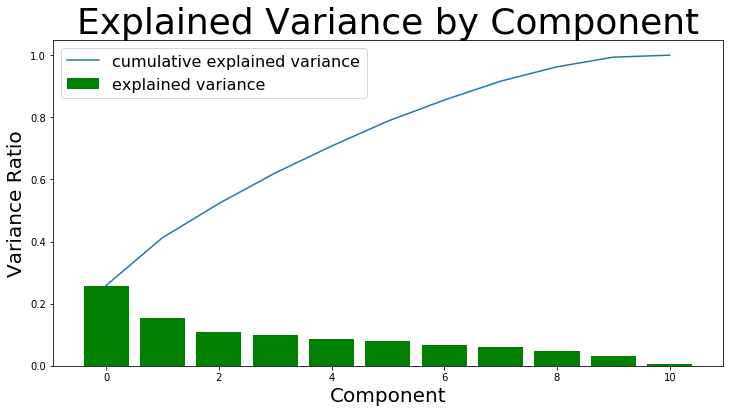

In [164]:
#Visually examining the cumulative sum of the explained variance
fig = plt.figure(figsize=(12,6))
plt.bar(np.array(range(len(var_exp))), 
        pca.explained_variance_ratio_, 
        color='g', 
        label='explained variance')
plt.plot(np.array(range(len(var_exp))), 
         np.cumsum(pca.explained_variance_ratio_), 
         label='cumulative explained variance')
plt.legend(fontsize=16)
plt.xlabel('Component', fontsize=20)
plt.ylabel('Variance Ratio', fontsize=20)
plt.title('Explained Variance by Component', fontsize=36)

Seven components decribe over 85% of the variance in the data, so seven components will be used to generate a linear regression model below.

#### Model 10: Using Linear Regression to Model the PCA-Transformed Data (Using 7 Components)

In [165]:
#Instantiating PCA:
n_components = 7
pca = PCA(n_components = 7)

#Fitting PCA model:
pca.fit(X_train_ss)

#Instantiating linear regression model
lr = LinearRegression()

#Creating Z_train and Z_test using PCA transformation
Z_train = pca.transform(X_train_ss)
Z_test = pca.transform(X_test_ss)

# Fit on Z_train.
lr.fit(Z_train, y_train)

#Generating predictions:
lr_preds = lr.predict(Z_test)

#Generating metrics and printing them to see how well the model performed:
print(f'Intercept: {lr.intercept_}')

#Generating and displaying a dataframe with the Beta coefficients:
df_coeffs = pd.DataFrame()
df_coeffs['Features'] = ['component_' + str(i) for i in range(n_components)]
df_coeffs['Beta Coefficient'] = lr.coef_
display(df_coeffs)

#Generating metrics and printing them to see how well the model performed:
print(gs.best_params_)
model_train_score_9 = lr.score(Z_train, y_train)
model_test_score_9 = lr.score(Z_test, y_test)
model_cv_score_mean_9 = cross_val_score(lr, Z_train, y_train, cv=5).mean()
model_r2_score_9 = r2_score(y_test, lr_preds)

#Printing the r2 score if the average number of fatalities of the train set is used as a baseline model to 
#predict test set hurricane fatalities:
print(f'Baseline R2 score (baseline: average train set hurricane fatalities): {r2_score(y_test, baseline_array)}')

#Generating and displaying the model metrics dataframe
df_metrics = pd.DataFrame(columns = ['Model', 'Train Score', 'Test Score', 
                                     'Cross-Validation Score', 'R2 Score of Preds'])
df_metrics.loc[0] = ['LR_AllFeatures_AllData', lr_train_score, lr_test_score, lr_cv_scores_mean, lr_rev_test_score]
df_metrics.loc[1] = ['LR_AllFeatures_NoKatrina', lr_train_score_1, lr_test_score_1, 
                     lr_cv_scores_mean_1, lr_rev_test_score_1]
df_metrics.loc[2] = ['LR_NoKatrinaNoPopulationAtOneTimePt', lr_train_score_2, lr_test_score_2, 
                     lr_cv_scores_mean_2, lr_rev_test_score_2]
df_metrics.loc[3] = ['KNN Regressor (Using GridSearchCV)', model_train_score_3, model_test_score_3, 
                     model_cv_score_3, knn_rev_test_score_3]
df_metrics.loc[4] = ['Decision Tree (Using GridSearchCV)', model_train_score_4, model_test_score_4, 
                     model_cv_score_4, model_r2_score_4]
df_metrics.loc[5] = ['Bagged Decision Trees (Using GridSearchCV)', model_train_score_5, model_test_score_5, 
                     model_cv_score_5, model_r2_score_5]
df_metrics.loc[6] = ['Random Forest (Using GridSearchCV)', model_train_score_6, model_test_score_6, 
                     model_cv_score_6, model_r2_score_6]
df_metrics.loc[7] = ['Extra Trees (Using GridSearchCV)', model_train_score_7, model_test_score_7, 
                     model_cv_score_7, model_r2_score_7]
df_metrics.loc[8] = ['AdaBoost (Using GridSearchCV)', model_train_score_8, model_test_score_8, 
                     model_cv_score_8, model_r2_score_8]
df_metrics.loc[9] = ['LR on PCA-Transformed Data (7 Components)', model_train_score_9, model_test_score_9, 
                     model_cv_score_mean_9, model_r2_score_9]

#Looking at the metrics df:
df_metrics

Intercept: 7.04


,Features,Beta Coefficient
0,component_0,3.127034
1,component_1,1.328054
2,component_2,3.284173
3,component_3,-0.852278
4,component_4,2.384257
5,component_5,-1.636291
6,component_6,-1.085852


{'base_estimator__max_depth': 1, 'base_estimator__max_features': 2, 'base_estimator__min_samples_split': 6, 'n_estimators': 10}
Baseline R2 score (baseline: average train set hurricane fatalities): -0.14435878608984432


,Model,Train Score,Test Score,Cross-Validation Score,R2 Score of Preds
0,LR_AllFeatures_AllData,0.305486,0.257909,0.059371,0.002454
1,LR_AllFeatures_NoKatrina,0.333031,0.167197,0.129873,0.080535
2,LR_NoKatrinaNoPopulationAtOneTimePt,0.312377,0.176862,0.141273,0.029977
3,KNN Regressor (Using GridSearchCV),0.144446,0.073921,-0.183934,0.073921
4,Decision Tree (Using GridSearchCV),0.907366,0.452629,-1.175827,0.452629
5,Bagged Decision Trees (Using GridSearchCV),0.815201,0.081431,-0.357224,0.081431
6,Random Forest (Using GridSearchCV),0.449472,-1.077538,-0.345032,-1.077538
7,Extra Trees (Using GridSearchCV),0.102054,0.168077,-0.065633,0.168077
8,AdaBoost (Using GridSearchCV),0.061289,-0.498629,-0.081210,-0.498629
9,LR on PCA-Transformed Data (7 Components),0.166915,0.183226,-0.945768,0.183226


The test score surpassed the train score, so more components will be used to see how this affects the model.

Eight components decribe nearly 92% of the variance in the data, so eight components will be used to generate a linear regression model below.

#### Model 11: Using Linear Regression to Model the PCA-Transformed Data (Using 8 Components)

In [166]:
#Instantiating PCA:
n_components = 8
pca = PCA(n_components = 8)

#Fitting PCA model:
pca.fit(X_train_ss)

#Instantiating linear regression model
lr = LinearRegression()

#Creating Z_train and Z_test using PCA transformation
Z_train = pca.transform(X_train_ss)
Z_test = pca.transform(X_test_ss)

# Fit on Z_train.
lr.fit(Z_train, y_train)

#Generating predictions:
lr_preds = lr.predict(Z_test)

#Generating metrics and printing them to see how well the model performed:
print(f'Intercept: {lr.intercept_}')

#Generating and displaying a dataframe with the Beta coefficients:
df_coeffs = pd.DataFrame()
df_coeffs['Features'] = ['component_' + str(i) for i in range(n_components)]
df_coeffs['Beta Coefficient'] = lr.coef_
display(df_coeffs)

#Generating metrics and printing them to see how well the model performed:
print(gs.best_params_)
model_train_score_10 = lr.score(Z_train, y_train)
model_test_score_10 = lr.score(Z_test, y_test)
model_cv_score_mean_10 = cross_val_score(lr, Z_train, y_train, cv=5).mean()
model_r2_score_10 = r2_score(y_test, lr_preds)

#Printing the r2 score if the average number of fatalities of the train set is used as a baseline model to 
#predict test set hurricane fatalities:
print(f'Baseline R2 score (baseline: average train set hurricane fatalities): {r2_score(y_test, baseline_array)}')

#Generating and displaying the model metrics dataframe
df_metrics = pd.DataFrame(columns = ['Model', 'Train Score', 'Test Score', 
                                     'Cross-Validation Score', 'R2 Score of Preds'])
df_metrics.loc[0] = ['LR_AllFeatures_AllData', lr_train_score, lr_test_score, lr_cv_scores_mean, lr_rev_test_score]
df_metrics.loc[1] = ['LR_AllFeatures_NoKatrina', lr_train_score_1, lr_test_score_1, 
                     lr_cv_scores_mean_1, lr_rev_test_score_1]
df_metrics.loc[2] = ['LR_NoKatrinaNoPopulationAtOneTimePt', lr_train_score_2, lr_test_score_2, 
                     lr_cv_scores_mean_2, lr_rev_test_score_2]
df_metrics.loc[3] = ['KNN Regressor (Using GridSearchCV)', model_train_score_3, model_test_score_3, 
                     model_cv_score_3, knn_rev_test_score_3]
df_metrics.loc[4] = ['Decision Tree (Using GridSearchCV)', model_train_score_4, model_test_score_4, 
                     model_cv_score_4, model_r2_score_4]
df_metrics.loc[5] = ['Bagged Decision Trees (Using GridSearchCV)', model_train_score_5, model_test_score_5, 
                     model_cv_score_5, model_r2_score_5]
df_metrics.loc[6] = ['Random Forest (Using GridSearchCV)', model_train_score_6, model_test_score_6, 
                     model_cv_score_6, model_r2_score_6]
df_metrics.loc[7] = ['Extra Trees (Using GridSearchCV)', model_train_score_7, model_test_score_7, 
                     model_cv_score_7, model_r2_score_7]
df_metrics.loc[8] = ['AdaBoost (Using GridSearchCV)', model_train_score_8, model_test_score_8, 
                     model_cv_score_8, model_r2_score_8]
df_metrics.loc[9] = ['LR on PCA-Transformed Data (7 Components)', model_train_score_9, model_test_score_9, 
                     model_cv_score_mean_9, model_r2_score_9]
df_metrics.loc[10] = ['LR on PCA-Transformed Data (8 Components)', model_train_score_10, model_test_score_10, 
                     model_cv_score_mean_10, model_r2_score_10]

#Looking at the metrics df:
df_metrics

Intercept: 7.04


,Features,Beta Coefficient
0,component_0,3.127034
1,component_1,1.328054
2,component_2,3.284173
3,component_3,-0.852278
4,component_4,2.384257
5,component_5,-1.636291
6,component_6,-1.085852
7,component_7,0.308964


{'base_estimator__max_depth': 1, 'base_estimator__max_features': 2, 'base_estimator__min_samples_split': 6, 'n_estimators': 10}
Baseline R2 score (baseline: average train set hurricane fatalities): -0.14435878608984432


,Model,Train Score,Test Score,Cross-Validation Score,R2 Score of Preds
0,LR_AllFeatures_AllData,0.305486,0.257909,0.059371,0.002454
1,LR_AllFeatures_NoKatrina,0.333031,0.167197,0.129873,0.080535
2,LR_NoKatrinaNoPopulationAtOneTimePt,0.312377,0.176862,0.141273,0.029977
3,KNN Regressor (Using GridSearchCV),0.144446,0.073921,-0.183934,0.073921
4,Decision Tree (Using GridSearchCV),0.907366,0.452629,-1.175827,0.452629
5,Bagged Decision Trees (Using GridSearchCV),0.815201,0.081431,-0.357224,0.081431
6,Random Forest (Using GridSearchCV),0.449472,-1.077538,-0.345032,-1.077538
7,Extra Trees (Using GridSearchCV),0.102054,0.168077,-0.065633,0.168077
8,AdaBoost (Using GridSearchCV),0.061289,-0.498629,-0.081210,-0.498629
9,LR on PCA-Transformed Data (7 Components),0.166915,0.183226,-0.945768,0.183226


The test score surpassed the train score, so more components will be used to see how this affects the model.

Nine components decribe approximately 96% of the variance in the data, so nine components will be used to generate a linear regression model below.  

#### Model 12: Using Linear Regression to Model the PCA-Transformed Data (Using 9 Components)

In [167]:
#Instantiating PCA:
n_components = 9
pca = PCA(n_components = 9)

#Fitting PCA model:
pca.fit(X_train_ss)

#Instantiating linear regression model
lr = LinearRegression()

#Creating Z_train and Z_test using PCA transformation
Z_train = pca.transform(X_train_ss)
Z_test = pca.transform(X_test_ss)

# Fit on Z_train.
lr.fit(Z_train, y_train)

#Generating predictions:
lr_preds = lr.predict(Z_test)

#Generating metrics and printing them to see how well the model performed:
print(f'Intercept: {lr.intercept_}')

#Generating and displaying a dataframe with the Beta coefficients:
df_coeffs = pd.DataFrame()
df_coeffs['Features'] = ['component_' + str(i) for i in range(n_components)]
df_coeffs['Beta Coefficient'] = lr.coef_
display(df_coeffs)

#Generating metrics and printing them to see how well the model performed:
print(gs.best_params_)
model_train_score_11 = lr.score(Z_train, y_train)
model_test_score_11 = lr.score(Z_test, y_test)
model_cv_score_mean_11 = cross_val_score(lr, Z_train, y_train, cv=5).mean()
model_r2_score_11 = r2_score(y_test, lr_preds)

#Printing the r2 score if the average number of fatalities of the train set is used as a baseline model to 
#predict test set hurricane fatalities:
print(f'Baseline R2 score (baseline: average train set hurricane fatalities): {r2_score(y_test, baseline_array)}')

#Generating and displaying the model metrics dataframe
df_metrics = pd.DataFrame(columns = ['Model', 'Train Score', 'Test Score', 
                                     'Cross-Validation Score', 'R2 Score of Preds'])
df_metrics.loc[0] = ['LR_AllFeatures_AllData', lr_train_score, lr_test_score, lr_cv_scores_mean, lr_rev_test_score]
df_metrics.loc[1] = ['LR_AllFeatures_NoKatrina', lr_train_score_1, lr_test_score_1, 
                     lr_cv_scores_mean_1, lr_rev_test_score_1]
df_metrics.loc[2] = ['LR_NoKatrinaNoPopulationAtOneTimePt', lr_train_score_2, lr_test_score_2, 
                     lr_cv_scores_mean_2, lr_rev_test_score_2]
df_metrics.loc[3] = ['KNN Regressor (Using GridSearchCV)', model_train_score_3, model_test_score_3, 
                     model_cv_score_3, knn_rev_test_score_3]
df_metrics.loc[4] = ['Decision Tree (Using GridSearchCV)', model_train_score_4, model_test_score_4, 
                     model_cv_score_4, model_r2_score_4]
df_metrics.loc[5] = ['Bagged Decision Trees (Using GridSearchCV)', model_train_score_5, model_test_score_5, 
                     model_cv_score_5, model_r2_score_5]
df_metrics.loc[6] = ['Random Forest (Using GridSearchCV)', model_train_score_6, model_test_score_6, 
                     model_cv_score_6, model_r2_score_6]
df_metrics.loc[7] = ['Extra Trees (Using GridSearchCV)', model_train_score_7, model_test_score_7, 
                     model_cv_score_7, model_r2_score_7]
df_metrics.loc[8] = ['AdaBoost (Using GridSearchCV)', model_train_score_8, model_test_score_8, 
                     model_cv_score_8, model_r2_score_8]
df_metrics.loc[9] = ['LR on PCA-Transformed Data (7 Components)', model_train_score_9, model_test_score_9, 
                     model_cv_score_mean_9, model_r2_score_9]
df_metrics.loc[10] = ['LR on PCA-Transformed Data (8 Components)', model_train_score_10, model_test_score_10, 
                     model_cv_score_mean_10, model_r2_score_10]
df_metrics.loc[11] = ['LR on PCA-Transformed Data (9 Components)', model_train_score_11, model_test_score_11, 
                     model_cv_score_mean_11, model_r2_score_11]

#Looking at the metrics df:
df_metrics

Intercept: 7.04


,Features,Beta Coefficient
0,component_0,3.127034
1,component_1,1.328054
2,component_2,3.284173
3,component_3,-0.852278
4,component_4,2.384257
5,component_5,-1.636291
6,component_6,-1.085852
7,component_7,0.308964
8,component_8,0.277900


{'base_estimator__max_depth': 1, 'base_estimator__max_features': 2, 'base_estimator__min_samples_split': 6, 'n_estimators': 10}
Baseline R2 score (baseline: average train set hurricane fatalities): -0.14435878608984432


,Model,Train Score,Test Score,Cross-Validation Score,R2 Score of Preds
0,LR_AllFeatures_AllData,0.305486,0.257909,0.059371,0.002454
1,LR_AllFeatures_NoKatrina,0.333031,0.167197,0.129873,0.080535
2,LR_NoKatrinaNoPopulationAtOneTimePt,0.312377,0.176862,0.141273,0.029977
3,KNN Regressor (Using GridSearchCV),0.144446,0.073921,-0.183934,0.073921
4,Decision Tree (Using GridSearchCV),0.907366,0.452629,-1.175827,0.452629
5,Bagged Decision Trees (Using GridSearchCV),0.815201,0.081431,-0.357224,0.081431
6,Random Forest (Using GridSearchCV),0.449472,-1.077538,-0.345032,-1.077538
7,Extra Trees (Using GridSearchCV),0.102054,0.168077,-0.065633,0.168077
8,AdaBoost (Using GridSearchCV),0.061289,-0.498629,-0.081210,-0.498629
9,LR on PCA-Transformed Data (7 Components),0.166915,0.183226,-0.945768,0.183226


The test score surpassed the train score, so more components will be used to see how this affects the model.

Ten components decribe approximately 99% of the variance in the data, so ten components will be used to generate a linear regression model below.  

#### Model 13: Using Linear Regression to Model the PCA-Transformed Data (Using 10 Components)

In [168]:
#Instantiating PCA:
n_components = 10
pca = PCA(n_components = 10)

#Fitting PCA model:
pca.fit(X_train_ss)

#Instantiating linear regression model
lr = LinearRegression()

#Creating Z_train and Z_test using PCA transformation
Z_train = pca.transform(X_train_ss)
Z_test = pca.transform(X_test_ss)

# Fit on Z_train.
lr.fit(Z_train, y_train)

#Generating predictions:
lr_preds = lr.predict(Z_test)

#Generating metrics and printing them to see how well the model performed:
print(f'Intercept: {lr.intercept_}')

#Generating and displaying a dataframe with the Beta coefficients:
df_coeffs = pd.DataFrame()
df_coeffs['Features'] = ['component_' + str(i) for i in range(n_components)]
df_coeffs['Beta Coefficient'] = lr.coef_
display(df_coeffs)

#Generating metrics and printing them to see how well the model performed:
print(gs.best_params_)
model_train_score_12 = lr.score(Z_train, y_train)
model_test_score_12 = lr.score(Z_test, y_test)
model_cv_score_mean_12 = cross_val_score(lr, Z_train, y_train, cv=5).mean()
model_r2_score_12 = r2_score(y_test, lr_preds)

#Printing the r2 score if the average number of fatalities of the train set is used as a baseline model to 
#predict test set hurricane fatalities:
print(f'Baseline R2 score (baseline: average train set hurricane fatalities): {r2_score(y_test, baseline_array)}')

#Generating and displaying the model metrics dataframe
df_metrics = pd.DataFrame(columns = ['Model', 'Train Score', 'Test Score', 
                                     'Cross-Validation Score', 'R2 Score of Preds'])
df_metrics.loc[0] = ['LR_AllFeatures_AllData', lr_train_score, lr_test_score, lr_cv_scores_mean, lr_rev_test_score]
df_metrics.loc[1] = ['LR_AllFeatures_NoKatrina', lr_train_score_1, lr_test_score_1, 
                     lr_cv_scores_mean_1, lr_rev_test_score_1]
df_metrics.loc[2] = ['LR_NoKatrinaNoPopulationAtOneTimePt', lr_train_score_2, lr_test_score_2, 
                     lr_cv_scores_mean_2, lr_rev_test_score_2]
df_metrics.loc[3] = ['KNN Regressor (Using GridSearchCV)', model_train_score_3, model_test_score_3, 
                     model_cv_score_3, knn_rev_test_score_3]
df_metrics.loc[4] = ['Decision Tree (Using GridSearchCV)', model_train_score_4, model_test_score_4, 
                     model_cv_score_4, model_r2_score_4]
df_metrics.loc[5] = ['Bagged Decision Trees (Using GridSearchCV)', model_train_score_5, model_test_score_5, 
                     model_cv_score_5, model_r2_score_5]
df_metrics.loc[6] = ['Random Forest (Using GridSearchCV)', model_train_score_6, model_test_score_6, 
                     model_cv_score_6, model_r2_score_6]
df_metrics.loc[7] = ['Extra Trees (Using GridSearchCV)', model_train_score_7, model_test_score_7, 
                     model_cv_score_7, model_r2_score_7]
df_metrics.loc[8] = ['AdaBoost (Using GridSearchCV)', model_train_score_8, model_test_score_8, 
                     model_cv_score_8, model_r2_score_8]
df_metrics.loc[9] = ['LR on PCA-Transformed Data (7 Components)', model_train_score_9, model_test_score_9, 
                     model_cv_score_mean_9, model_r2_score_9]
df_metrics.loc[10] = ['LR on PCA-Transformed Data (8 Components)', model_train_score_10, model_test_score_10, 
                     model_cv_score_mean_10, model_r2_score_10]
df_metrics.loc[11] = ['LR on PCA-Transformed Data (9 Components)', model_train_score_11, model_test_score_11, 
                     model_cv_score_mean_11, model_r2_score_11]
df_metrics.loc[12] = ['LR on PCA-Transformed Data (10 Components)', model_train_score_12, model_test_score_12, 
                     model_cv_score_mean_12, model_r2_score_12]

#Looking at the metrics df:
df_metrics

Intercept: 7.039999999999999


,Features,Beta Coefficient
0,component_0,3.127034
1,component_1,1.328054
2,component_2,3.284173
3,component_3,-0.852278
4,component_4,2.384257
5,component_5,-1.636291
6,component_6,-1.085852
7,component_7,0.308964
8,component_8,0.277900
9,component_9,5.368329


{'base_estimator__max_depth': 1, 'base_estimator__max_features': 2, 'base_estimator__min_samples_split': 6, 'n_estimators': 10}
Baseline R2 score (baseline: average train set hurricane fatalities): -0.14435878608984432


,Model,Train Score,Test Score,Cross-Validation Score,R2 Score of Preds
0,LR_AllFeatures_AllData,0.305486,0.257909,0.059371,0.002454
1,LR_AllFeatures_NoKatrina,0.333031,0.167197,0.129873,0.080535
2,LR_NoKatrinaNoPopulationAtOneTimePt,0.312377,0.176862,0.141273,0.029977
3,KNN Regressor (Using GridSearchCV),0.144446,0.073921,-0.183934,0.073921
4,Decision Tree (Using GridSearchCV),0.907366,0.452629,-1.175827,0.452629
5,Bagged Decision Trees (Using GridSearchCV),0.815201,0.081431,-0.357224,0.081431
6,Random Forest (Using GridSearchCV),0.449472,-1.077538,-0.345032,-1.077538
7,Extra Trees (Using GridSearchCV),0.102054,0.168077,-0.065633,0.168077
8,AdaBoost (Using GridSearchCV),0.061289,-0.498629,-0.081210,-0.498629
9,LR on PCA-Transformed Data (7 Components),0.166915,0.183226,-0.945768,0.183226


The train score surpassed the test score, but the test score and the R2 score of the predictions and the cross-validation scores are now less than 0.  The cross-validation score is also less than the baseline R2 score, so this model does not perform better than the baseline model.

KNN will be performed with PCA-transformed data below to see if KNN will outperform LR when using PCA-transformed data.

#### Model 14: Using K-Nearest Neighbors to Model the PCA-Transformed Data (Using 7 Components)

In [169]:
#Instantiating PCA:
n_components = 7
pca = PCA(n_components = 7)

#Fitting PCA model:
pca.fit(X_train_ss)

#Creating Z_train and Z_test using PCA transformation
Z_train = pca.transform(X_train_ss)
Z_test = pca.transform(X_test_ss)

#Instantiating Model:
knn = KNeighborsRegressor()

#Setting up the parameters that will be inspected during GridSearchCV:
knn_params = {
    'n_neighbors': [2, 3, 4, 5, 10, 15, 20] #looking at various numbers of neighbors
}

#Doing the gridsearch:
gs = GridSearchCV(knn, param_grid = knn_params, cv=3)

#Fitting the model:
gs.fit(Z_train, y_train) #using SVD-transformed data instead of StandardScaled scaled data

#Generating predictions:
gs_preds = gs.predict(Z_test) #using SVD-transformed data instead of StandardScaled scaled data

#Finding the R2 score after reversing the Power Transform:
model_r2_score_13 = r2_score(y_test, gs_preds)

#Generating metrics and printing them to see how well the model performed:
print(gs.best_params_)
model_train_score_13 = gs.score(Z_train, y_train)
model_test_score_13 = gs.score(Z_test, y_test)
model_cv_score_13 = gs.best_score_ #GridSearch does CV, so this is a CV score

#Printing the r2 score if the average number of fatalities of the train set is used as a baseline model to 
#predict test set hurricane fatalities:
print(f'Baseline R2 score (baseline: average train set hurricane fatalities): {r2_score(y_test, baseline_array)}')

#Generating and displaying the model metrics dataframe
df_metrics = pd.DataFrame(columns = ['Model', 'Train Score', 'Test Score', 
                                     'Cross-Validation Score', 'R2 Score of Preds'])
df_metrics.loc[0] = ['LR_AllFeatures_AllData', lr_train_score, lr_test_score, lr_cv_scores_mean, lr_rev_test_score]
df_metrics.loc[1] = ['LR_AllFeatures_NoKatrina', lr_train_score_1, lr_test_score_1, 
                     lr_cv_scores_mean_1, lr_rev_test_score_1]
df_metrics.loc[2] = ['LR_NoKatrinaNoPopulationAtOneTimePt', lr_train_score_2, lr_test_score_2, 
                     lr_cv_scores_mean_2, lr_rev_test_score_2]
df_metrics.loc[3] = ['KNN Regressor (Using GridSearchCV)', model_train_score_3, model_test_score_3, 
                     model_cv_score_3, knn_rev_test_score_3]
df_metrics.loc[4] = ['Decision Tree (Using GridSearchCV)', model_train_score_4, model_test_score_4, 
                     model_cv_score_4, model_r2_score_4]
df_metrics.loc[5] = ['Bagged Decision Trees (Using GridSearchCV)', model_train_score_5, model_test_score_5, 
                     model_cv_score_5, model_r2_score_5]
df_metrics.loc[6] = ['Random Forest (Using GridSearchCV)', model_train_score_6, model_test_score_6, 
                     model_cv_score_6, model_r2_score_6]
df_metrics.loc[7] = ['Extra Trees (Using GridSearchCV)', model_train_score_7, model_test_score_7, 
                     model_cv_score_7, model_r2_score_7]
df_metrics.loc[8] = ['AdaBoost (Using GridSearchCV)', model_train_score_8, model_test_score_8, 
                     model_cv_score_8, model_r2_score_8]
df_metrics.loc[9] = ['LR on PCA-Transformed Data (7 Components)', model_train_score_9, model_test_score_9, 
                     model_cv_score_mean_9, model_r2_score_9]
df_metrics.loc[10] = ['LR on PCA-Transformed Data (8 Components)', model_train_score_10, model_test_score_10, 
                     model_cv_score_mean_10, model_r2_score_10]
df_metrics.loc[11] = ['LR on PCA-Transformed Data (9 Components)', model_train_score_11, model_test_score_11, 
                     model_cv_score_mean_11, model_r2_score_11]
df_metrics.loc[12] = ['LR on PCA-Transformed Data (10 Components)', model_train_score_12, model_test_score_12, 
                     model_cv_score_mean_12, model_r2_score_12]
df_metrics.loc[13] = ['KNN on PCA-Transformed Data (GS Used, 7 Components)', model_train_score_13, model_test_score_13, 
                     model_cv_score_13, model_r2_score_13]


#Looking at the metrics df:
df_metrics

{'n_neighbors': 20}
Baseline R2 score (baseline: average train set hurricane fatalities): -0.14435878608984432


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,Model,Train Score,Test Score,Cross-Validation Score,R2 Score of Preds
0,LR_AllFeatures_AllData,0.305486,0.257909,0.059371,0.002454
1,LR_AllFeatures_NoKatrina,0.333031,0.167197,0.129873,0.080535
2,LR_NoKatrinaNoPopulationAtOneTimePt,0.312377,0.176862,0.141273,0.029977
3,KNN Regressor (Using GridSearchCV),0.144446,0.073921,-0.183934,0.073921
4,Decision Tree (Using GridSearchCV),0.907366,0.452629,-1.175827,0.452629
5,Bagged Decision Trees (Using GridSearchCV),0.815201,0.081431,-0.357224,0.081431
6,Random Forest (Using GridSearchCV),0.449472,-1.077538,-0.345032,-1.077538
7,Extra Trees (Using GridSearchCV),0.102054,0.168077,-0.065633,0.168077
8,AdaBoost (Using GridSearchCV),0.061289,-0.498629,-0.081210,-0.498629
9,LR on PCA-Transformed Data (7 Components),0.166915,0.183226,-0.945768,0.183226


The test score surpassed the train score, so more components will be used to see how this affects the model.

Eight components decribe nearly 92% of the variance in the data, so eight components will be used to generate a KNN regression model below.

#### Model 15: Using K-Nearest Neighbors to Model the PCA-Transformed Data (Using 8 Components)

In [170]:
#Instantiating PCA:
n_components = 8
pca = PCA(n_components = 8)

#Fitting PCA model:
pca.fit(X_train_ss)

#Creating Z_train and Z_test using PCA transformation
Z_train = pca.transform(X_train_ss)
Z_test = pca.transform(X_test_ss)

#Instantiating Model:
knn = KNeighborsRegressor()

#Setting up the parameters that will be inspected during GridSearchCV:
knn_params = {
    'n_neighbors': [2, 3, 4, 5, 10, 15, 20] #looking at various numbers of neighbors
}

#Doing the gridsearch:
gs = GridSearchCV(knn, param_grid = knn_params, cv=3)

#Fitting the model:
gs.fit(Z_train, y_train) #using SVD-transformed data instead of StandardScaled scaled data

#Generating predictions:
gs_preds = gs.predict(Z_test) #using SVD-transformed data instead of StandardScaled scaled data

#Finding the R2 score after reversing the Power Transform:
model_r2_score_14 = r2_score(y_test, gs_preds)

#Generating metrics and printing them to see how well the model performed:
print(gs.best_params_)
model_train_score_14 = gs.score(Z_train, y_train)
model_test_score_14 = gs.score(Z_test, y_test)
model_cv_score_14 = gs.best_score_

#Printing the r2 score if the average number of fatalities of the train set is used as a baseline model to 
#predict test set hurricane fatalities:
print(f'Baseline R2 score (baseline: average train set hurricane fatalities): {r2_score(y_test, baseline_array)}')

#Generating and displaying the model metrics dataframe
df_metrics = pd.DataFrame(columns = ['Model', 'Train Score', 'Test Score', 
                                     'Cross-Validation Score', 'R2 Score of Preds'])
df_metrics.loc[0] = ['LR_AllFeatures_AllData', lr_train_score, lr_test_score, lr_cv_scores_mean, lr_rev_test_score]
df_metrics.loc[1] = ['LR_AllFeatures_NoKatrina', lr_train_score_1, lr_test_score_1, 
                     lr_cv_scores_mean_1, lr_rev_test_score_1]
df_metrics.loc[2] = ['LR_NoKatrinaNoPopulationAtOneTimePt', lr_train_score_2, lr_test_score_2, 
                     lr_cv_scores_mean_2, lr_rev_test_score_2]
df_metrics.loc[3] = ['KNN Regressor (Using GridSearchCV)', model_train_score_3, model_test_score_3, 
                     model_cv_score_3, knn_rev_test_score_3]
df_metrics.loc[4] = ['Decision Tree (Using GridSearchCV)', model_train_score_4, model_test_score_4, 
                     model_cv_score_4, model_r2_score_4]
df_metrics.loc[5] = ['Bagged Decision Trees (Using GridSearchCV)', model_train_score_5, model_test_score_5, 
                     model_cv_score_5, model_r2_score_5]
df_metrics.loc[6] = ['Random Forest (Using GridSearchCV)', model_train_score_6, model_test_score_6, 
                     model_cv_score_6, model_r2_score_6]
df_metrics.loc[7] = ['Extra Trees (Using GridSearchCV)', model_train_score_7, model_test_score_7, 
                     model_cv_score_7, model_r2_score_7]
df_metrics.loc[8] = ['AdaBoost (Using GridSearchCV)', model_train_score_8, model_test_score_8, 
                     model_cv_score_8, model_r2_score_8]
df_metrics.loc[9] = ['LR on PCA-Transformed Data (7 Components)', model_train_score_9, model_test_score_9, 
                     model_cv_score_mean_9, model_r2_score_9]
df_metrics.loc[10] = ['LR on PCA-Transformed Data (8 Components)', model_train_score_10, model_test_score_10, 
                     model_cv_score_mean_10, model_r2_score_10]
df_metrics.loc[11] = ['LR on PCA-Transformed Data (9 Components)', model_train_score_11, model_test_score_11, 
                     model_cv_score_mean_11, model_r2_score_11]
df_metrics.loc[12] = ['LR on PCA-Transformed Data (10 Components)', model_train_score_12, model_test_score_12, 
                     model_cv_score_mean_12, model_r2_score_12]
df_metrics.loc[13] = ['KNN on PCA-Transformed Data (GS Used, 7 Components)', model_train_score_13, model_test_score_13, 
                     model_cv_score_13, model_r2_score_13]
df_metrics.loc[14] = ['KNN on PCA-Transformed Data (GS Used, 8 Components)', model_train_score_14, model_test_score_14, 
                     model_cv_score_14, model_r2_score_14]


#Looking at the metrics df:
df_metrics

{'n_neighbors': 20}
Baseline R2 score (baseline: average train set hurricane fatalities): -0.14435878608984432


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,Model,Train Score,Test Score,Cross-Validation Score,R2 Score of Preds
0,LR_AllFeatures_AllData,0.305486,0.257909,0.059371,0.002454
1,LR_AllFeatures_NoKatrina,0.333031,0.167197,0.129873,0.080535
2,LR_NoKatrinaNoPopulationAtOneTimePt,0.312377,0.176862,0.141273,0.029977
3,KNN Regressor (Using GridSearchCV),0.144446,0.073921,-0.183934,0.073921
4,Decision Tree (Using GridSearchCV),0.907366,0.452629,-1.175827,0.452629
5,Bagged Decision Trees (Using GridSearchCV),0.815201,0.081431,-0.357224,0.081431
6,Random Forest (Using GridSearchCV),0.449472,-1.077538,-0.345032,-1.077538
7,Extra Trees (Using GridSearchCV),0.102054,0.168077,-0.065633,0.168077
8,AdaBoost (Using GridSearchCV),0.061289,-0.498629,-0.081210,-0.498629
9,LR on PCA-Transformed Data (7 Components),0.166915,0.183226,-0.945768,0.183226


The test score surpassed the train score, so more components will be used to see how this affects the model.

Nine components decribe approximately 96% of the variance in the data, so nine components will be used to generate a KNN regression model below.  

#### Model 16: Using K-Nearest Neighbors to Model the PCA-Transformed Data (Using 9 Components)

In [171]:
#Instantiating PCA:
n_components = 9
pca = PCA(n_components = 9)

#Fitting PCA model:
pca.fit(X_train_ss)

#Creating Z_train and Z_test using PCA transformation
Z_train = pca.transform(X_train_ss)
Z_test = pca.transform(X_test_ss)

#Instantiating Model:
knn = KNeighborsRegressor()

#Setting up the parameters that will be inspected during GridSearchCV:
knn_params = {
    'n_neighbors': [2, 3, 4, 5, 10, 15, 20] #looking at various numbers of neighbors
}

#Doing the gridsearch:
gs = GridSearchCV(knn, param_grid = knn_params, cv=3)

#Fitting the model:
gs.fit(Z_train, y_train) #using SVD-transformed data instead of StandardScaled scaled data

#Generating predictions:
gs_preds = gs.predict(Z_test) #using SVD-transformed data instead of StandardScaled scaled data

#Finding the R2 score after reversing the Power Transform:
model_r2_score_15 = r2_score(y_test, gs_preds)

#Generating metrics and printing them to see how well the model performed:
print(gs.best_params_)
model_train_score_15 = gs.score(Z_train, y_train)
model_test_score_15 = gs.score(Z_test, y_test)
model_cv_score_15 = gs.best_score_

#Printing the r2 score if the average number of fatalities of the train set is used as a baseline model to 
#predict test set hurricane fatalities:
print(f'Baseline R2 score (baseline: average train set hurricane fatalities): {r2_score(y_test, baseline_array)}')

#Generating and displaying the model metrics dataframe
df_metrics = pd.DataFrame(columns = ['Model', 'Train Score', 'Test Score', 
                                     'Cross-Validation Score', 'R2 Score of Preds'])
df_metrics.loc[0] = ['LR_AllFeatures_AllData', lr_train_score, lr_test_score, lr_cv_scores_mean, lr_rev_test_score]
df_metrics.loc[1] = ['LR_AllFeatures_NoKatrina', lr_train_score_1, lr_test_score_1, 
                     lr_cv_scores_mean_1, lr_rev_test_score_1]
df_metrics.loc[2] = ['LR_NoKatrinaNoPopulationAtOneTimePt', lr_train_score_2, lr_test_score_2, 
                     lr_cv_scores_mean_2, lr_rev_test_score_2]
df_metrics.loc[3] = ['KNN Regressor (Using GridSearchCV)', model_train_score_3, model_test_score_3, 
                     model_cv_score_3, knn_rev_test_score_3]
df_metrics.loc[4] = ['Decision Tree (Using GridSearchCV)', model_train_score_4, model_test_score_4, 
                     model_cv_score_4, model_r2_score_4]
df_metrics.loc[5] = ['Bagged Decision Trees (Using GridSearchCV)', model_train_score_5, model_test_score_5, 
                     model_cv_score_5, model_r2_score_5]
df_metrics.loc[6] = ['Random Forest (Using GridSearchCV)', model_train_score_6, model_test_score_6, 
                     model_cv_score_6, model_r2_score_6]
df_metrics.loc[7] = ['Extra Trees (Using GridSearchCV)', model_train_score_7, model_test_score_7, 
                     model_cv_score_7, model_r2_score_7]
df_metrics.loc[8] = ['AdaBoost (Using GridSearchCV)', model_train_score_8, model_test_score_8, 
                     model_cv_score_8, model_r2_score_8]
df_metrics.loc[9] = ['LR on PCA-Transformed Data (7 Components)', model_train_score_9, model_test_score_9, 
                     model_cv_score_mean_9, model_r2_score_9]
df_metrics.loc[10] = ['LR on PCA-Transformed Data (8 Components)', model_train_score_10, model_test_score_10, 
                     model_cv_score_mean_10, model_r2_score_10]
df_metrics.loc[11] = ['LR on PCA-Transformed Data (9 Components)', model_train_score_11, model_test_score_11, 
                     model_cv_score_mean_11, model_r2_score_11]
df_metrics.loc[12] = ['LR on PCA-Transformed Data (10 Components)', model_train_score_12, model_test_score_12, 
                     model_cv_score_mean_12, model_r2_score_12]
df_metrics.loc[13] = ['KNN on PCA-Transformed Data (GS Used, 7 Components)', model_train_score_13, model_test_score_13, 
                     model_cv_score_13, model_r2_score_13]
df_metrics.loc[14] = ['KNN on PCA-Transformed Data (GS Used, 8 Components)', model_train_score_14, model_test_score_14, 
                     model_cv_score_14, model_r2_score_14]
df_metrics.loc[15] = ['KNN on PCA-Transformed Data (GS Used, 9 Components)', model_train_score_15, model_test_score_15, 
                     model_cv_score_15, model_r2_score_15]


#Looking at the metrics df:
df_metrics

{'n_neighbors': 20}
Baseline R2 score (baseline: average train set hurricane fatalities): -0.14435878608984432


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,Model,Train Score,Test Score,Cross-Validation Score,R2 Score of Preds
0,LR_AllFeatures_AllData,0.305486,0.257909,0.059371,0.002454
1,LR_AllFeatures_NoKatrina,0.333031,0.167197,0.129873,0.080535
2,LR_NoKatrinaNoPopulationAtOneTimePt,0.312377,0.176862,0.141273,0.029977
3,KNN Regressor (Using GridSearchCV),0.144446,0.073921,-0.183934,0.073921
4,Decision Tree (Using GridSearchCV),0.907366,0.452629,-1.175827,0.452629
5,Bagged Decision Trees (Using GridSearchCV),0.815201,0.081431,-0.357224,0.081431
6,Random Forest (Using GridSearchCV),0.449472,-1.077538,-0.345032,-1.077538
7,Extra Trees (Using GridSearchCV),0.102054,0.168077,-0.065633,0.168077
8,AdaBoost (Using GridSearchCV),0.061289,-0.498629,-0.081210,-0.498629
9,LR on PCA-Transformed Data (7 Components),0.166915,0.183226,-0.945768,0.183226


The test score surpassed the train score, so more components will be used to see how this affects the model.

Ten components decribe approximately 99% of the variance in the data, so ten components will be used to generate a KNN regression model below.  

#### Model 17: Using K-Nearest Neighbors to Model the PCA-Transformed Data (Using 10 Components)

In [172]:
#Instantiating PCA:
n_components = 10
pca = PCA(n_components = 10)

#Fitting PCA model:
pca.fit(X_train_ss)

#Creating Z_train and Z_test using PCA transformation
Z_train = pca.transform(X_train_ss)
Z_test = pca.transform(X_test_ss)

#Instantiating Model:
knn = KNeighborsRegressor()

#Setting up the parameters that will be inspected during GridSearchCV:
knn_params = {
    'n_neighbors': [2, 3, 4, 5, 10, 15, 20] #looking at various numbers of neighbors
}

#Doing the gridsearch:
gs = GridSearchCV(knn, param_grid = knn_params, cv=3)

#Fitting the model:
gs.fit(Z_train, y_train) #using SVD-transformed data instead of StandardScaled scaled data

#Generating predictions:
gs_preds = gs.predict(Z_test) #using SVD-transformed data instead of StandardScaled scaled data

#Finding the R2 score after reversing the Power Transform:
model_r2_score_16 = r2_score(y_test, gs_preds)

#Generating metrics and printing them to see how well the model performed:
print(gs.best_params_)
model_train_score_16 = gs.score(Z_train, y_train)
model_test_score_16 = gs.score(Z_test, y_test)
model_cv_score_16 = gs.best_score_

#Printing the r2 score if the average number of fatalities of the train set is used as a baseline model to 
#predict test set hurricane fatalities:
print(f'Baseline R2 score (baseline: average train set hurricane fatalities): {r2_score(y_test, baseline_array)}')

#Generating and displaying the model metrics dataframe
df_metrics = pd.DataFrame(columns = ['Model', 'Train Score', 'Test Score', 
                                     'Cross-Validation Score', 'R2 Score of Preds'])
df_metrics.loc[0] = ['LR_AllFeatures_AllData', lr_train_score, lr_test_score, lr_cv_scores_mean, lr_rev_test_score]
df_metrics.loc[1] = ['LR_AllFeatures_NoKatrina', lr_train_score_1, lr_test_score_1, 
                     lr_cv_scores_mean_1, lr_rev_test_score_1]
df_metrics.loc[2] = ['LR_NoKatrinaNoPopulationAtOneTimePt', lr_train_score_2, lr_test_score_2, 
                     lr_cv_scores_mean_2, lr_rev_test_score_2]
df_metrics.loc[3] = ['KNN Regressor (Using GridSearchCV)', model_train_score_3, model_test_score_3, 
                     model_cv_score_3, knn_rev_test_score_3]
df_metrics.loc[4] = ['Decision Tree (Using GridSearchCV)', model_train_score_4, model_test_score_4, 
                     model_cv_score_4, model_r2_score_4]
df_metrics.loc[5] = ['Bagged Decision Trees (Using GridSearchCV)', model_train_score_5, model_test_score_5, 
                     model_cv_score_5, model_r2_score_5]
df_metrics.loc[6] = ['Random Forest (Using GridSearchCV)', model_train_score_6, model_test_score_6, 
                     model_cv_score_6, model_r2_score_6]
df_metrics.loc[7] = ['Extra Trees (Using GridSearchCV)', model_train_score_7, model_test_score_7, 
                     model_cv_score_7, model_r2_score_7]
df_metrics.loc[8] = ['AdaBoost (Using GridSearchCV)', model_train_score_8, model_test_score_8, 
                     model_cv_score_8, model_r2_score_8]
df_metrics.loc[9] = ['LR on PCA-Transformed Data (7 Components)', model_train_score_9, model_test_score_9, 
                     model_cv_score_mean_9, model_r2_score_9]
df_metrics.loc[10] = ['LR on PCA-Transformed Data (8 Components)', model_train_score_10, model_test_score_10, 
                     model_cv_score_mean_10, model_r2_score_10]
df_metrics.loc[11] = ['LR on PCA-Transformed Data (9 Components)', model_train_score_11, model_test_score_11, 
                     model_cv_score_mean_11, model_r2_score_11]
df_metrics.loc[12] = ['LR on PCA-Transformed Data (10 Components)', model_train_score_12, model_test_score_12, 
                     model_cv_score_mean_12, model_r2_score_12]
df_metrics.loc[13] = ['KNN on PCA-Transformed Data (GS Used, 7 Components)', model_train_score_13, model_test_score_13, 
                     model_cv_score_13, model_r2_score_13]
df_metrics.loc[14] = ['KNN on PCA-Transformed Data (GS Used, 8 Components)', model_train_score_14, model_test_score_14, 
                     model_cv_score_14, model_r2_score_14]
df_metrics.loc[15] = ['KNN on PCA-Transformed Data (GS Used, 9 Components)', model_train_score_15, model_test_score_15, 
                     model_cv_score_15, model_r2_score_15]
df_metrics.loc[16] = ['KNN on PCA-Transformed Data (GS Used, 10 Components)', model_train_score_16, model_test_score_16, 
                     model_cv_score_16, model_r2_score_16]


#Looking at the metrics df:
df_metrics

{'n_neighbors': 20}
Baseline R2 score (baseline: average train set hurricane fatalities): -0.14435878608984432


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,Model,Train Score,Test Score,Cross-Validation Score,R2 Score of Preds
0,LR_AllFeatures_AllData,0.305486,0.257909,0.059371,0.002454
1,LR_AllFeatures_NoKatrina,0.333031,0.167197,0.129873,0.080535
2,LR_NoKatrinaNoPopulationAtOneTimePt,0.312377,0.176862,0.141273,0.029977
3,KNN Regressor (Using GridSearchCV),0.144446,0.073921,-0.183934,0.073921
4,Decision Tree (Using GridSearchCV),0.907366,0.452629,-1.175827,0.452629
5,Bagged Decision Trees (Using GridSearchCV),0.815201,0.081431,-0.357224,0.081431
6,Random Forest (Using GridSearchCV),0.449472,-1.077538,-0.345032,-1.077538
7,Extra Trees (Using GridSearchCV),0.102054,0.168077,-0.065633,0.168077
8,AdaBoost (Using GridSearchCV),0.061289,-0.498629,-0.081210,-0.498629
9,LR on PCA-Transformed Data (7 Components),0.166915,0.183226,-0.945768,0.183226


The test score surpassed the train score, so more components will be used to see how this affects the model.

11 components decribe 100% of the variance in the data, so 11 components will be used to generate a KNN regression model below.  

#### Model 18: Using K-Nearest Neighbors to Model the PCA-Transformed Data (Using 11 Components)

In [173]:
#Instantiating PCA:
n_components = 11
pca = PCA(n_components = 11)

#Fitting PCA model:
pca.fit(X_train_ss)

#Creating Z_train and Z_test using PCA transformation
Z_train = pca.transform(X_train_ss)
Z_test = pca.transform(X_test_ss)

#Instantiating Model:
knn = KNeighborsRegressor()

#Setting up the parameters that will be inspected during GridSearchCV:
knn_params = {
    'n_neighbors': [2, 3, 4, 5, 10, 15, 20] #looking at various numbers of neighbors
}

#Doing the gridsearch:
gs = GridSearchCV(knn, param_grid = knn_params, cv=3)

#Fitting the model:
gs.fit(Z_train, y_train) #using SVD-transformed data instead of StandardScaled scaled data

#Generating predictions:
gs_preds = gs.predict(Z_test) #using SVD-transformed data instead of StandardScaled scaled data

#Finding the R2 score after reversing the Power Transform:
model_r2_score_17 = r2_score(y_test, gs_preds)

#Generating metrics and printing them to see how well the model performed:
print(gs.best_params_)
model_train_score_17 = gs.score(Z_train, y_train)
model_test_score_17 = gs.score(Z_test, y_test)
model_cv_score_17 = gs.best_score_

#Printing the r2 score if the average number of fatalities of the train set is used as a baseline model to 
#predict test set hurricane fatalities:
print(f'Baseline R2 score (baseline: average train set hurricane fatalities): {r2_score(y_test, baseline_array)}')

#Generating and displaying the model metrics dataframe
df_metrics = pd.DataFrame(columns = ['Model', 'Train Score', 'Test Score', 
                                     'Cross-Validation Score', 'R2 Score of Preds'])
df_metrics.loc[0] = ['LR_AllFeatures_AllData', lr_train_score, lr_test_score, lr_cv_scores_mean, lr_rev_test_score]
df_metrics.loc[1] = ['LR_AllFeatures_NoKatrina', lr_train_score_1, lr_test_score_1, 
                     lr_cv_scores_mean_1, lr_rev_test_score_1]
df_metrics.loc[2] = ['LR_NoKatrinaNoPopulationAtOneTimePt', lr_train_score_2, lr_test_score_2, 
                     lr_cv_scores_mean_2, lr_rev_test_score_2]
df_metrics.loc[3] = ['KNN Regressor (Using GridSearchCV)', model_train_score_3, model_test_score_3, 
                     model_cv_score_3, knn_rev_test_score_3]
df_metrics.loc[4] = ['Decision Tree (Using GridSearchCV)', model_train_score_4, model_test_score_4, 
                     model_cv_score_4, model_r2_score_4]
df_metrics.loc[5] = ['Bagged Decision Trees (Using GridSearchCV)', model_train_score_5, model_test_score_5, 
                     model_cv_score_5, model_r2_score_5]
df_metrics.loc[6] = ['Random Forest (Using GridSearchCV)', model_train_score_6, model_test_score_6, 
                     model_cv_score_6, model_r2_score_6]
df_metrics.loc[7] = ['Extra Trees (Using GridSearchCV)', model_train_score_7, model_test_score_7, 
                     model_cv_score_7, model_r2_score_7]
df_metrics.loc[8] = ['AdaBoost (Using GridSearchCV)', model_train_score_8, model_test_score_8, 
                     model_cv_score_8, model_r2_score_8]
df_metrics.loc[9] = ['LR on PCA-Transformed Data (7 Components)', model_train_score_9, model_test_score_9, 
                     model_cv_score_mean_9, model_r2_score_9]
df_metrics.loc[10] = ['LR on PCA-Transformed Data (8 Components)', model_train_score_10, model_test_score_10, 
                     model_cv_score_mean_10, model_r2_score_10]
df_metrics.loc[11] = ['LR on PCA-Transformed Data (9 Components)', model_train_score_11, model_test_score_11, 
                     model_cv_score_mean_11, model_r2_score_11]
df_metrics.loc[12] = ['LR on PCA-Transformed Data (10 Components)', model_train_score_12, model_test_score_12, 
                     model_cv_score_mean_12, model_r2_score_12]
df_metrics.loc[13] = ['KNN on PCA-Transformed Data (GS Used, 7 Components)', model_train_score_13, model_test_score_13, 
                     model_cv_score_13, model_r2_score_13]
df_metrics.loc[14] = ['KNN on PCA-Transformed Data (GS Used, 8 Components)', model_train_score_14, model_test_score_14, 
                     model_cv_score_14, model_r2_score_14]
df_metrics.loc[15] = ['KNN on PCA-Transformed Data (GS Used, 9 Components)', model_train_score_15, model_test_score_15, 
                     model_cv_score_15, model_r2_score_15]
df_metrics.loc[16] = ['KNN on PCA-Transformed Data (GS Used, 10 Components)', model_train_score_16, model_test_score_16, 
                     model_cv_score_16, model_r2_score_16]
df_metrics.loc[17] = ['KNN on PCA-Transformed Data (GS Used, 11 Components)', model_train_score_17, model_test_score_17, 
                     model_cv_score_17, model_r2_score_17]

#Looking at the metrics df:
df_metrics

{'n_neighbors': 20}
Baseline R2 score (baseline: average train set hurricane fatalities): -0.14435878608984432


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,Model,Train Score,Test Score,Cross-Validation Score,R2 Score of Preds
0,LR_AllFeatures_AllData,0.305486,0.257909,0.059371,0.002454
1,LR_AllFeatures_NoKatrina,0.333031,0.167197,0.129873,0.080535
2,LR_NoKatrinaNoPopulationAtOneTimePt,0.312377,0.176862,0.141273,0.029977
3,KNN Regressor (Using GridSearchCV),0.144446,0.073921,-0.183934,0.073921
4,Decision Tree (Using GridSearchCV),0.907366,0.452629,-1.175827,0.452629
5,Bagged Decision Trees (Using GridSearchCV),0.815201,0.081431,-0.357224,0.081431
6,Random Forest (Using GridSearchCV),0.449472,-1.077538,-0.345032,-1.077538
7,Extra Trees (Using GridSearchCV),0.102054,0.168077,-0.065633,0.168077
8,AdaBoost (Using GridSearchCV),0.061289,-0.498629,-0.081210,-0.498629
9,LR on PCA-Transformed Data (7 Components),0.166915,0.183226,-0.945768,0.183226


The test score is still greater than the train score, even when all PCA components are used.  The KNN models on PCA-transformed data have low cross-validation scores, so they did not perform much better than the baseline model.

### Conclusiong and Future Steps

It would be interesting to see if we can improve the models we have built or if other models perform better.  It looks like the descision tree model (Model 5, at index 4 in the table above) has a great test score but a poor train score in comparison (even though that is the best test score of the models in the table above) showing the model is overfit.  The cross-validation score is very poor, so that should be investigated in the future.  Other models did not perform as well as hoped.  The train-test-split ratio could be altered, and other actions can be taken to improve these models such as removing more outliers (as long as it can be proven that removal of more outliers is appropriate).  

It would be interesting to try other models such as neural networks.  It would also be interesting to look at data during and after 2004 which has more data related to low wind, moderate wind, and high wind in quadrants.  It would also be helpful to look at hurricane changes with time and whether other time points would have been more informative than the time points that were used in this analysis.  It would be helpful to see hurricane evacuation information and flood information and storm surge information as well which might help increase understanding about fatalities.  According to National Geographic, "Ninety percent of all hurricane deaths result from storm surges," so storm surge information could be very useful and could be added to this analysis in the future.  Also rip current information would be useful since several deaths were caused by people drowning in rip currents (as we saw during collection of fatality data from NOAA resources).  Hurricane fatality may also be significantly dependent on human behavior and other factors.  Even if storm risks were understood and there were required hurricane evacuations, people may still stay in place due to personal preference, fear of looting, etc.  This analysis has been informative in that it has shown that there is more to learn.  We were able to model how fatal hurricanes are likely to be, and the first few linear models that were built performed better than the baseline model (which assumes a hurricane will have the average number of fatalities of the train set).  There is a need for further research, data collection, and analysis to improve models to predict how many fatalities are likely (given features used to build the models). 

Source:
https://www.nationalgeographic.com/environment/natural-disasters/hurricanes/